#### NOVA IMS / BSc in Data Science / Text Mining 2024/2025
### <b>Group Project: "Solving the Hyderabadi Word Soup"</b>
#### Notebook `Multilabel Classification`

#### Group:
- `Miguel Matos - 20221925`
- `Nuno Leandro - 20221861`
- `Patrícia Bezerra - 20221907`
- `Rita Silva - 20221920`
- `Vasco Capão - 20221906`

#### <font color='#BFD72F'>Table of Contents </font> <a class="anchor" id='toc'></a> 
- [0. Imports](#p0)
- [1. Specific Data Preparation](#p1)
    - [1.1 Data Preprocessing](#p1-1)
- [2. Model Implementation](#p2)
    - [2.1 Term Frequency-Inverse Document Frequency (TF-IDF)](#p2-1)
    - [2.2 Bag of Words (BoW)](#p2-2)
    - [2.3 Hermetic Classifier](#p2-3)  
        - [2.3.1 TF-IDF](#p2-3-1)
        - [2.3.2 Doc2Vec](#p2-3-2)
- [3. Grid Search](#p3)
- [4. Evaluation](#p4)
- [5. Conclusion](#p5)

<font color='#BFD72F' size=8>Multilabel Classification (Information Requirement 3311)</font> <a class="anchor" id="p0-0"></a>

"How well can we classify a restaurant’s cuisine type using the
content of their reviews as input?"

<font color='#BFD72F' size=7>0. Imports</font> <a class="anchor" id="p0"></a>

In [1]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/miguelmatos/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
from utils.pipeline_project import *
import utils.pipeline_project as pipeline_project
from utils.functions import *

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/miguelmatos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/miguelmatos/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/miguelmatos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/miguelmatos/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<font color='#BFD72F' size=7>1. Specific Data Preparation</font> <a class="anchor" id="p1"></a>

[Back to TOC](#toc)

In [9]:
main_df = pd.read_csv("complete_df.csv")
main_df.head()

Unnamed: 0             Name  \
0           0  Beyond Flavours   
1           1  Beyond Flavours   
2           2  Beyond Flavours   
3           3  Beyond Flavours   
4           4  Beyond Flavours   

                                              Review  Rating  \
0  The ambience was good, food was quite good . h...     5.0   
1  Ambience is too good for a pleasant evening. S...     5.0   
2  A must try.. great food great ambience. Thnx f...     5.0   
3  Soumen das and Arun was a great guy. Only beca...     5.0   
4  Food is good.we ordered Kodi drumsticks and ba...     5.0   

                                            Cuisines  \
0  Chinese, Continental, Kebab, European, South I...   
1  Chinese, Continental, Kebab, European, South I...   
2  Chinese, Continental, Kebab, European, South I...   
3  Chinese, Continental, Kebab, European, South I...   
4  Chinese, Continental, Kebab, European, South I...   

                                     preproc_reviews  
0  ambience good food quite good saturday lunch c...  
1  ambience good pleasant evening service prompt ...  
2  must try great food great ambience thnx servic...  
3  soumen da arun great guy behavior sincerety go...  
4  food ordered kodi drumstick basket mutton biry...

Let's create a dataframe with the minimum required columns, so it's easier to understand what we need.

In [10]:
main_classification = main_df[["Review", "Cuisines"]]
main_classification.head()

Review  \
0  The ambience was good, food was quite good . h...   
1  Ambience is too good for a pleasant evening. S...   
2  A must try.. great food great ambience. Thnx f...   
3  Soumen das and Arun was a great guy. Only beca...   
4  Food is good.we ordered Kodi drumsticks and ba...   

                                            Cuisines  
0  Chinese, Continental, Kebab, European, South I...  
1  Chinese, Continental, Kebab, European, South I...  
2  Chinese, Continental, Kebab, European, South I...  
3  Chinese, Continental, Kebab, European, South I...  
4  Chinese, Continental, Kebab, European, South I...

Now, let's convert the 'cuisines' column so that each row contains a list of cuisine labels.

In [11]:
# Convert the labels column to a list of labels
main_classification["labels"] = main_classification["Cuisines"].map(lambda content : re.split(",",re.sub("\s","",content)))

In [12]:
# Extract the unique genres
unique_genres = []

for film_genres_list in list(main_classification["labels"]):
    for genre in film_genres_list:
        if genre not in unique_genres:
            unique_genres.append(genre)

len(unique_genres)

42

We'll apply One-Hot Encoding to the full dataset so that we can count how many times each label has appeared.

In [13]:
main_classification_expl = pd.DataFrame()
main_classification_expl["raw_content"] = main_classification["Review"]

for label in unique_genres:
    main_classification_expl["{}_label".format(label)] = main_classification["labels"].map(lambda labels_list : 1 if label in labels_list else 0)

In [14]:
main_classification_expl.head()

raw_content  Chinese_label  \
0  The ambience was good, food was quite good . h...              1   
1  Ambience is too good for a pleasant evening. S...              1   
2  A must try.. great food great ambience. Thnx f...              1   
3  Soumen das and Arun was a great guy. Only beca...              1   
4  Food is good.we ordered Kodi drumsticks and ba...              1   

   Continental_label  Kebab_label  European_label  SouthIndian_label  \
0                  1            1               1                  1   
1                  1            1               1                  1   
2                  1            1               1                  1   
3                  1            1               1                  1   
4                  1            1               1                  1   

   NorthIndian_label  Biryani_label  Asian_label  Mediterranean_label  ...  \
0                  1              0            0                    0  ...   
1                  1              0            0                    0  ...   
2                  1              0            0                    0  ...   
3                  1              0            0                    0  ...   
4                  1              0            0                    0  ...   

   Hyderabadi_label  Cafe_label  Spanish_label  Wraps_label  Thai_label  \
0                 0           0              0            0           0   
1                 0           0              0            0           0   
2                 0           0              0            0           0   
3                 0           0              0            0           0   
4                 0           0              0            0           0   

   Indonesian_label  ModernIndian_label  Momos_label  Pizza_label  \
0                 0                   0            0            0   
1                 0                   0            0            0   
2                 0                   0            0            0   
3                 0                   0            0            0   
4                 0                   0            0            0   

   NorthEastern_label  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  

[5 rows x 43 columns]

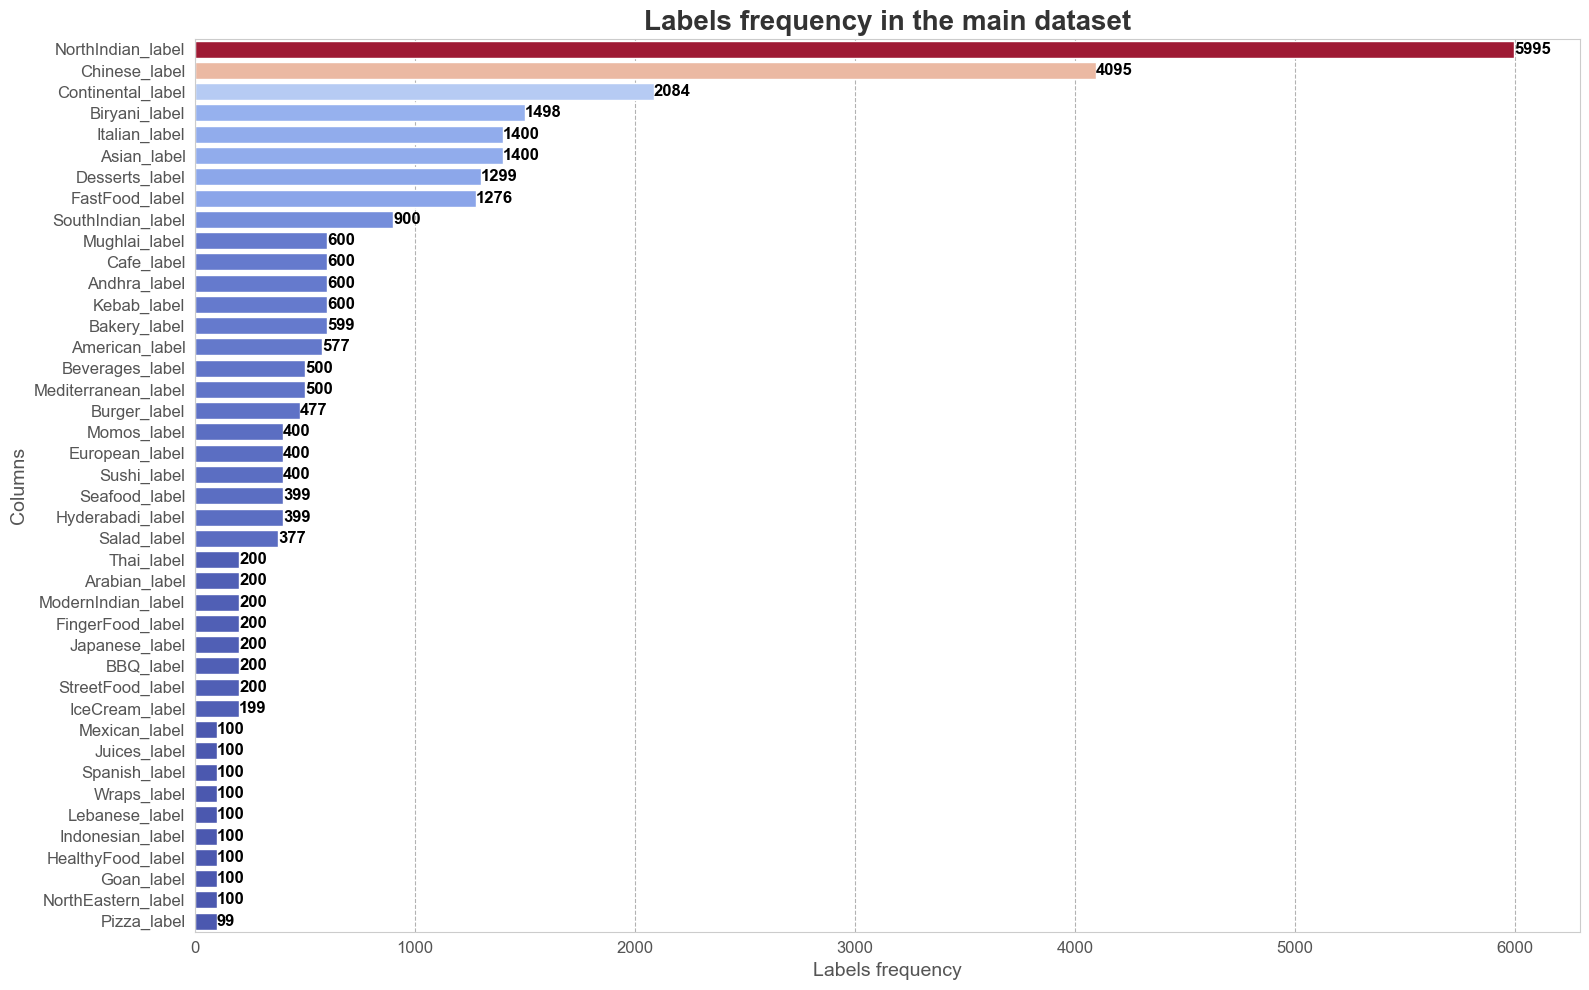

In [15]:
plotter_3(main_classification_expl, "Labels frequency in the main dataset")

Since it is clear that some labels are poorly represented, let's examine their relationship with other labels to identify any dependencies.

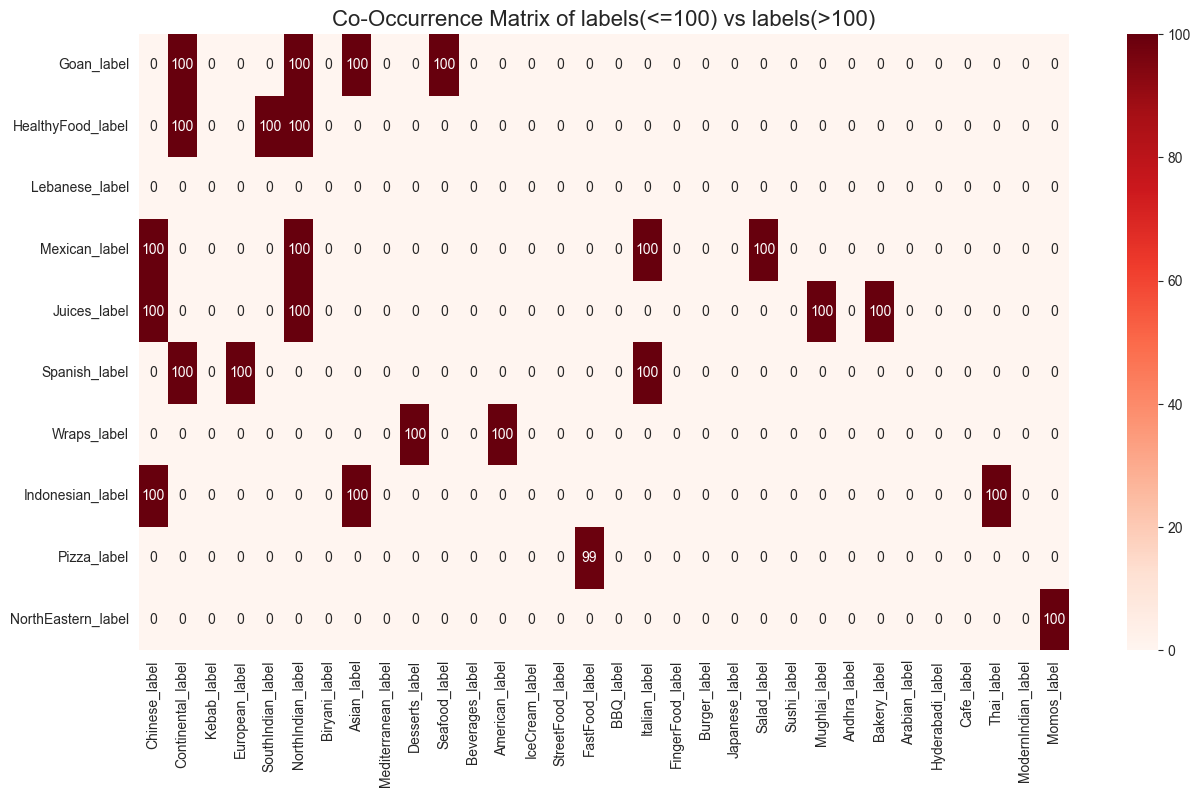

In [16]:
# Extract binary columns (cuisine labels)
binary_columns = main_classification_expl.select_dtypes(include=[np.number]).columns
binary_data = main_classification_expl[binary_columns]

# Calculate total occurrences for each label
label_counts = binary_data.sum(axis=0)

# Split labels into two groups: rare (<=100) and more common (>100)
rare_labels = label_counts[label_counts <= 100].index
common_labels = label_counts[label_counts > 100].index

# Filter data for rare and common labels
rare_data = binary_data[rare_labels]
common_data = binary_data[common_labels]

# Compute the co-occurrence matrix between rare and common labels
co_occurrence_matrix = rare_data.T.dot(common_data)

# Plot the co-occurrence matrix as a heatmap with actual numbers
plt.figure(figsize=(15, 8))
sns.heatmap(
    co_occurrence_matrix, 
    annot=True,            
    fmt="d",               
    cmap="Reds", 
    xticklabels=common_labels, 
    yticklabels=rare_labels,
    cbar=True
)
plt.title("Co-Occurrence Matrix of labels(<=100) vs labels(>100)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


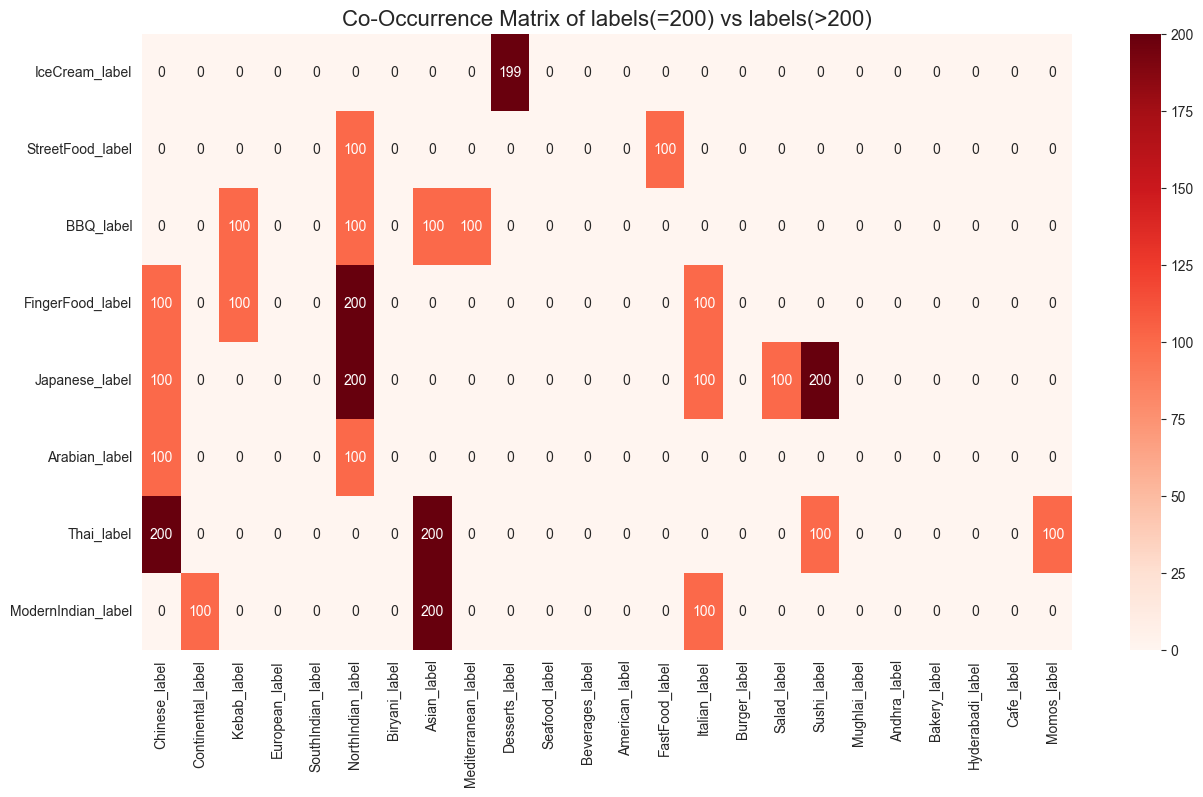

In [17]:
label_counts = label_counts[label_counts > 100]

rare_labels = label_counts[label_counts <= 200].index
common_labels = label_counts[label_counts > 200].index

# Filter data for rare and common labels
rare_data = binary_data[rare_labels]
common_data = binary_data[common_labels]

# Compute the co-occurrence matrix between rare and common labels
co_occurrence_matrix = rare_data.T.dot(common_data)

# Plot the co-occurrence matrix as a heatmap with actual numbers
plt.figure(figsize=(15, 8))
sns.heatmap(
    co_occurrence_matrix, 
    annot=True,            
    fmt="d",               
    cmap="Reds", 
    xticklabels=common_labels, 
    yticklabels=rare_labels,
    cbar=True
)
plt.title("Co-Occurrence Matrix of labels(=200) vs labels(>200)", fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

Labels with a frequency of 199 or less will be removed. These labels are consistently associated with other labels, making them redundant. For instance, the 'Wraps_label' always appears alongside 'Desserts_label' and 'American_label'. If we replaced 'Wraps_label' with the others and then eliminated duplicates, we would inadvertently remove valid labels. To avoid this issue, we will directly remove these redundant labels. All labels on this list have similar dependencies, as exemplified in the case above.
The only exception is 'Lebanese_label,' which always appears alone. Therefore, it will not be removed.

Below is the code to create a list of labels with a frequency of 199 or less. This list is named 'invalid_labels'.

In [18]:
# Calculate the frequency of each label in the co-occurence matrix by summing its occurrences across all rows
label_frequencies = main_classification_expl.iloc[:, 1:].sum()

# Filter labels that appear less than 200 times
invalid_labels = label_frequencies[label_frequencies <= 199].index.tolist()
invalid_labels.remove("Lebanese_label")
print(len(invalid_labels))
invalid_labels

10


['Goan_label',
 'HealthyFood_label',
 'IceCream_label',
 'Mexican_label',
 'Juices_label',
 'Spanish_label',
 'Wraps_label',
 'Indonesian_label',
 'Pizza_label',
 'NorthEastern_label']

Having analyzed the label distribution in the entire dataset and defined the labels to remove, we will now reduce the dataset by half to further decrease computational cost.

In [19]:
#Shuffling the dataset, so the data is more equally distributed.
main_classification = main_classification.sample(frac=1, random_state=20).reset_index(drop=True)

#Splittong the dataset
main_classification = main_classification.iloc[:5001, :]
#Shuffling the dataset again
main_classification = main_classification.sample(frac=1, random_state=20).reset_index(drop=True)

Now, we will apply One-Hot Encoding to the new smaller dataset to examine the label distribution and verify whether it remains consistent.

In [20]:
main_classification_expl = pd.DataFrame()
main_classification_expl["raw_content"] = main_classification["Review"]

for label in unique_genres:
    main_classification_expl["{}_label".format(label)] = main_classification["labels"].map(lambda labels_list : 1 if label in labels_list else 0)

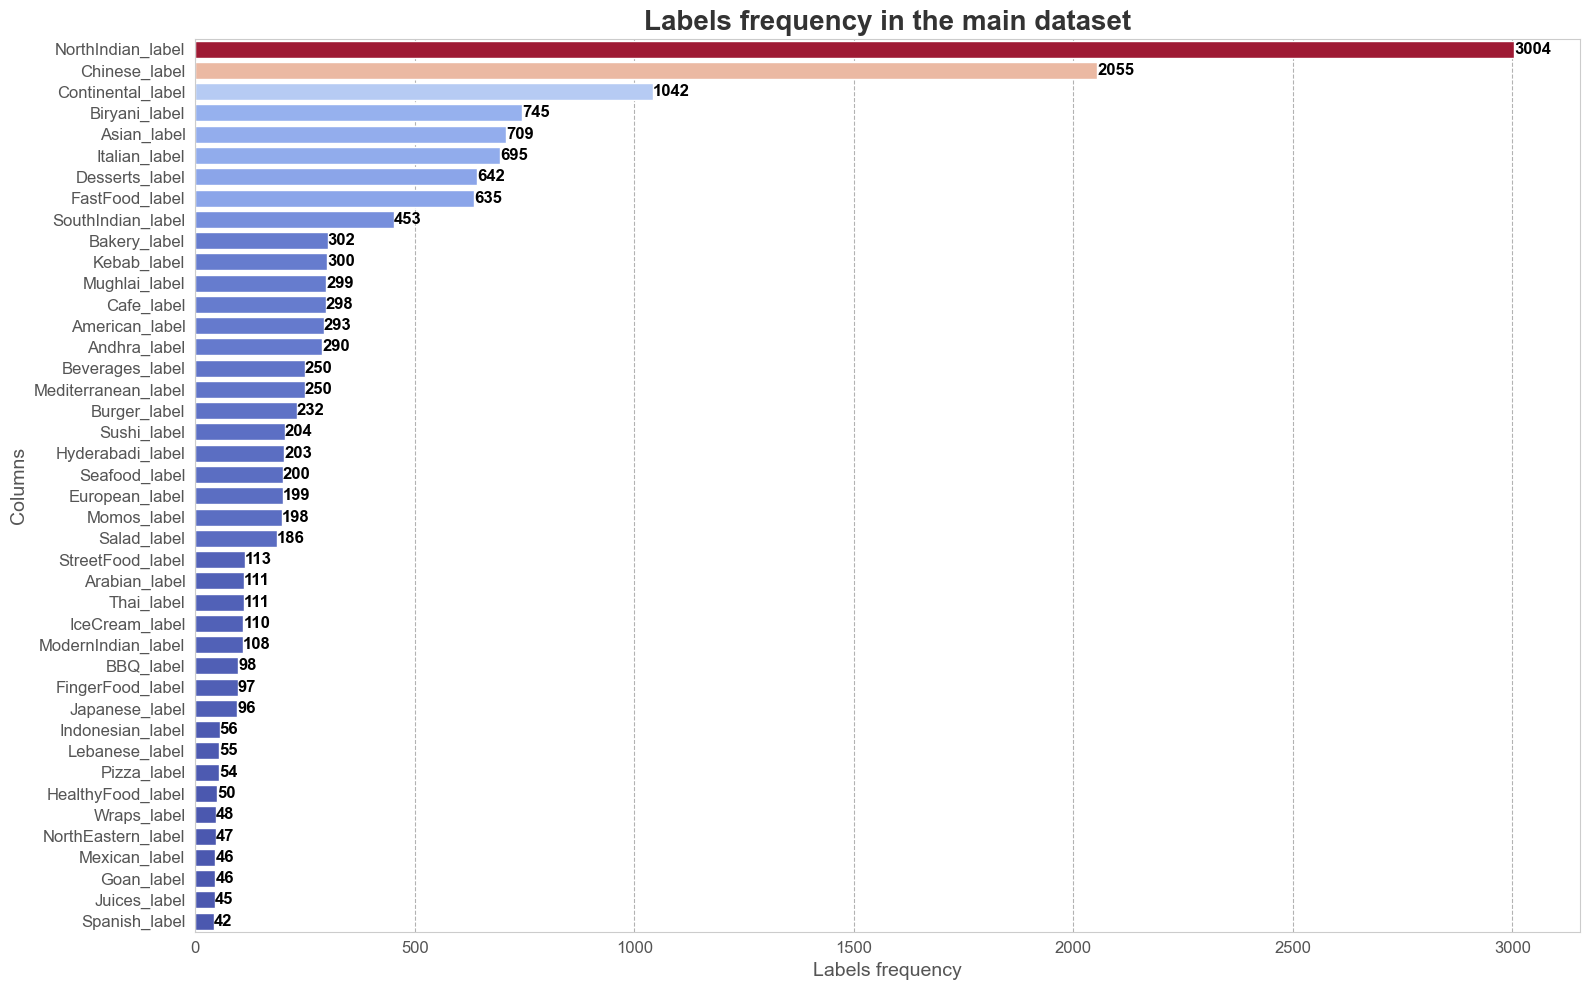

In [21]:
plotter_3(main_classification_expl, "Labels frequency in the main dataset")

As observed, the distribution appears very similar, so we can proceed to remove the 'invalid_labels' defined earlier.

The next cell addresses labels containing two words. For instance, 'Fast Food' will be renamed to 'FastFood.' This step ensures that we can successfully remove the 'invalid_labels' without encountering errors. This issue arises because, in the 'invalid_labels,' labels are represented in a format like 'IceCream_label.' If labels with two words remained separated, we would not be able to remove them effectively.

In [22]:
main_classification["Cuisines"] = join_multi_word_phrases(main_classification["Cuisines"])

Now, we will create a copy of the dataset in case further tests are needed after the grid search.

In [23]:
main_classification_2 = main_classification.copy()

In the next cell, we will drop the 'invalid_labels,' as shown in the output.

In [24]:
# Create a set of invalid labels for efficient lookup
invalid_labels_set = set(invalid_labels)

# Apply the filter to the 'Cuisines' column
main_classification['Filtered_Cuisines'] = main_classification['Cuisines'].apply(lambda x: filter_cuisines(x, invalid_labels_set))

# Display the updated dataframe with the filtered cuisines
main_classification[['Cuisines', 'Filtered_Cuisines']].head()


Cuisines  \
0                     NorthIndian, FastFood   
1                                  Lebanese   
2  Andhra, Biryani, Hyderabadi, NorthIndian   
3                           FastFood, Pizza   
4             NorthIndian, Chinese, Biryani   

                          Filtered_Cuisines  
0                     NorthIndian, FastFood  
1                                  Lebanese  
2  Andhra, Biryani, Hyderabadi, NorthIndian  
3                                  FastFood  
4             NorthIndian, Chinese, Biryani

Now, we will check the number of missing values in the new 'Filtered_Cuisines' column.

In [25]:
main_classification["Filtered_Cuisines"][main_classification["Filtered_Cuisines"] == ""] = np.nan
main_classification["Filtered_Cuisines"].isna().sum()

0

As we did previously, we created a column called 'labels' containing the cuisine types in a list. Now, we need to recreate that column, as we have removed some labels.

In [26]:
## Convert the labels column to a list of labels
main_classification["labels"] = main_classification["Filtered_Cuisines"].map(lambda content : re.split(",",re.sub("\s","",content)))

In the next cell, we will check how many labels we have now.

In [27]:
## Extract the unique genres
unique_genres = []

for film_genres_list in list(main_classification["labels"]):
    for genre in film_genres_list:
        if genre not in unique_genres:
            unique_genres.append(genre)

len(unique_genres)

32

As we can see, we now have 32 labels. We can verify that the labels were correctly removed, as we initially had 42 labels, removed 10, and now have 32. This confirms that the labels were correctly removed.

Once again, we need to apply One-Hot Encoding to the dataset, as we have eliminated some labels, and the last 'main_classification_expl' was not updated.

In [28]:
## Create a scratch dataset - "imdb_movies_explore" - to plot the number of movies by label and to generate TF-IDF word clouds by label
main_classification_expl = pd.DataFrame()
main_classification_expl["raw_content"] = main_classification["Review"]

for label in unique_genres:
    main_classification_expl["{}_label".format(label)] = main_classification["labels"].map(lambda labels_list : 1 if label in labels_list else 0)

The next step is to generate word clouds for each label. However, before doing so, we need to preprocess the reviews. In this preprocessing step, we will remove the words 'good', 'food', 'place', 'service', 'ambience', 'order', and 'taste'. As we observed in the preprocessing phase, these words appear frequently across all reviews and would not contribute to differentiating the most relevant terms in each word cloud.

In [29]:
main_classification_expl["wordcloud_text"] = main_classification_expl["raw_content"].apply(lambda content :\
                                                  pipeline_project.main_pipeline(str(content),
                                                                                  print_output=False,
                                                                                  no_stopwords=True,
                                                                                  lowercase =True,
                                                                                  lemmatized = True,
                                                                                  custom_stopwords= ["good", "food", "place", "service", "ambience", "order", "taste"],
                                                                                  no_punctuation = True, 
                                                                                  tokenized_output = False))

The following cell creates a list of lists, where each list represents a document containing all the reviews for a specific label. The variable 'corpus' holds all the reviews for each label. With this variable, we will be able to generate a word cloud for each label.

In [30]:
# Prepare a corpus of documents, so that each document consists of the concatenated overviews for each label
corpus = []
for label in unique_genres:
    label_doc = ""
    for movie in main_classification_expl["wordcloud_text"].loc[main_classification_expl["{}_label".format(label)]==1]: 
        label_doc = label_doc + " " + movie
    corpus.append(label_doc)

print("Length of unique_genres: {}; Length of corpus: {}".format(len(unique_genres), len(corpus)))

Length of unique_genres: 32; Length of corpus: 32


In [31]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")  
wc = WordCloud(background_color="white",max_words=120, width = 220,height = 220, color_func=lambda *args, **kwargs: (0,0,0))

In [32]:
# Generate word clouds for each genre label from the TF-IDF vectorisation of the corpus, storing the results in the "word_clouds" folder 
folder_relative_path = "Word_clouds"

if not os.path.exists(folder_relative_path):
    os.makedirs(folder_relative_path)

for idx, document in enumerate(corpus):
    genre_corpus_tfidf_td_matrix = bigram_tfidf_vectorizer.fit_transform(corpus)
    genre_corpus_tfidf_word_list = bigram_tfidf_vectorizer.get_feature_names_out()

    genre_corpus_vocabulary = pipeline_project.word_freq_calculator(genre_corpus_tfidf_td_matrix[idx].toarray(),\
                                                                        genre_corpus_tfidf_word_list, df_output=False)
    wc.generate_from_frequencies(genre_corpus_vocabulary)
    wc.to_file(os.path.join(folder_relative_path, "WC_"+unique_genres[idx]+"TFIDF.png"))

<font color='#BFD72F' size=6>1.1 Data Preprocessing</font> <a class="anchor" id="p1-1"></a>

[Back to TOC](#toc)

Creating pre-processed reviews for the main dataset. This column will be used only for testing purposes before the grid search.

In [33]:
preprocessor = pipeline_project.MainPipeline()

main_classification["preproc_content"] =\
      main_classification["Review"].map(lambda content : preprocessor.main_pipeline(content))

Now, we will perform binarization of the labels. This will result in binary lists of the labels, which we can use to evaluate future models.

In [34]:
mlb = MultiLabelBinarizer()
binarised_labels = mlb.fit_transform(main_classification["labels"])
main_classification["label_binary"] = binarised_labels.tolist()

As we have created a column of pre-processed reviews for testing, we will now create columns with TF-IDF vectors and BoW vectors for testing purposes as well.

In [35]:
##TF-IDF
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")

class_tfidf_td_matrix = bigram_tfidf_vectorizer.fit_transform(main_classification["preproc_content"]).toarray()
class_tfidf_td_matrix = csr_matrix(class_tfidf_td_matrix)
main_classification["tfidf_vector"] = list(class_tfidf_td_matrix)

In [36]:
#BOW 
bigram_bow_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r"(?u)\b\w+\b")

class_bow_td_matrix = bigram_bow_vectorizer.fit_transform(main_classification["preproc_content"]).toarray()
class_bow_td_matrix = csr_matrix(class_bow_td_matrix)
main_classification["tfidf_vector"] = list(class_bow_td_matrix)

In [37]:
main_classification.head()

Review  \
0  This place is usual hangout place for guys as ...   
1  The biryani here is very delicious, one should...   
2  Ordered C. Biryani & M. Biryani on 23.12.18......   
3                           right on time, this time   
4  its not biryani. its plain rice mixed with som...   

                                   Cuisines  \
0                     NorthIndian, FastFood   
1                                  Lebanese   
2  Andhra, Biryani, Hyderabadi, NorthIndian   
3                           FastFood, Pizza   
4             NorthIndian, Chinese, Biryani   

                                       labels  \
0                     [NorthIndian, FastFood]   
1                                  [Lebanese]   
2  [Andhra, Biryani, Hyderabadi, NorthIndian]   
3                                  [FastFood]   
4             [NorthIndian, Chinese, Biryani]   

                          Filtered_Cuisines  \
0                     NorthIndian, FastFood   
1                                  Lebanese   
2  Andhra, Biryani, Hyderabadi, NorthIndian   
3                                  FastFood   
4             NorthIndian, Chinese, Biryani   

                                     preproc_content  \
0  place usual hangout place guy allows enter cor...   
1  biryani delicious one must biryani visit hyder...   
2  ordered c biryani biryani worst biryani tasted...   
3                                    right time time   
4  biryani plain rice mixed masalai ordered resta...   

                                        label_binary  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...   
4  [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, ...   

                                        tfidf_vector  
0    (0, 3132)\t1\n  (0, 3133)\t1\n  (0, 3159)\t1...  
1    (0, 10222)\t2\n  (0, 10304)\t1\n  (0, 10567)...  
2    (0, 10222)\t3\n  (0, 10268)\t1\n  (0, 10531)...  
3    (0, 71762)\t1\n  (0, 71836)\t1\n  (0, 86649)...  
4    (0, 10222)\t1\n  (0, 10462)\t1\n  (0, 26201)...

<font color='#BFD72F' size=7>2. Model Implementation</font> <a class="anchor" id="p2"></a>

[Back to TOC](#toc)

<font color='#BFD72F' size=6>2.1 Term Frequency-Inverse Document Frequency (TF-IDF)</font> <a class="anchor" id="p2-1"></a>

First let's do some tests with the TF-IDF vector.

In [38]:
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(class_tfidf_td_matrix, binarised_labels, 
                                                    test_size=0.3, random_state=0)


In [39]:
#Test the OneVsRest classifier
ovm = OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=0, class_weight="balanced", C = 1)).fit(X_train_tf, y_train_tf)
y_pred_q1_ovm = ovm.predict(X_test_tf)

In [40]:
#Test the classifier Chain
cchain = ClassifierChain(LogisticRegression(solver='liblinear', random_state=1, class_weight="balanced", C = 1), order="random").fit(X_train_tf, y_train_tf)
y_pred_q1_cchain = cchain.predict(X_test_tf)

In [41]:
# OneVsRest Scores
fold_score_calculator(y_pred_q1_ovm, y_test_tf, verbose=True)

Accuracy: 0.13257828114590273 
Precision: 0.5486103486955345 
Recall: 0.4882231877429682 
F1: 0.4980126321338403


(0.13257828114590273,
 0.5486103486955345,
 0.4882231877429682,
 0.4980126321338403)

In [42]:
## ClassifierChain Scores
fold_score_calculator(y_pred_q1_cchain, y_test_tf, verbose=True)

Accuracy: 0.05596269153897402 
Precision: 0.4161480835893994 
Recall: 0.5069746169677567 
F1: 0.44155532740585673


(0.05596269153897402,
 0.4161480835893994,
 0.5069746169677567,
 0.44155532740585673)

<font color='#BFD72F' size=6>2.2 Bag of Words (BoW)</font> <a class="anchor" id="p2-2"></a>

[Back to TOC](#toc)

Now, let's proceed with some testing with the BOW vector.

In [43]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(class_bow_td_matrix, binarised_labels, 
                                                    test_size=0.3, random_state=0)

In [44]:
#Test the OneVsRest classifier
ovm = OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=0, class_weight="balanced", C = 1)).fit(X_train_b, y_train_b)
y_pred_q1_ovm = ovm.predict(X_test_b)

In [45]:
#Test the classifier Chain
cchain = ClassifierChain(LogisticRegression(solver='liblinear', random_state=1, class_weight="balanced", C = 1), order="random").fit(X_train_b, y_train_b)
y_pred_q1_cchain = cchain.predict(X_test_b)

In [46]:
## OneVsRest Scores
fold_score_calculator(y_pred_q1_ovm, y_test_tf, verbose=True)

Accuracy: 0.10792804796802132 
Precision: 0.5312064296383846 
Recall: 0.4989709581522982 
F1: 0.5000357265367041


(0.10792804796802132,
 0.5312064296383846,
 0.4989709581522982,
 0.5000357265367041)

In [47]:
## ClassifierChain Scores
fold_score_calculator(y_pred_q1_cchain, y_test_tf, verbose=True)

Accuracy: 0.12924716855429713 
Precision: 0.5113325393607671 
Recall: 0.5113194603247199 
F1: 0.5023556541058581


(0.12924716855429713,
 0.5113325393607671,
 0.5113194603247199,
 0.5023556541058581)

The BoW vectorizer performed slightly better than the TF-IDF in the tests we conducted, but the difference was not significant. Therefore, we will use both in the grid search.

<font color='#BFD72F' size=6>2.3 Hermetic Classifier </font> <a class="anchor" id="p2-3"></a>

<font color='#BFD72F' size=5>2.3.1 TF-IDF</font> <a class="anchor" id="p2-3-1"></a>

[Back to TOC](#toc)

First, we will test the hermetic classifier with the TF-IDF.

In [49]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(main_classification["Review"], binarised_labels, 
                                                    test_size=0.3, random_state=0)

In [50]:
bigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b") 
ml_class = ClassifierChain(LogisticRegression(solver='liblinear', random_state=0, class_weight="balanced"), order="random")
preprocessor = pipeline_project.MainPipeline()

hermetic_classifier = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, ml_class)

hermetic_classifier.fit(X_train_2,y_train_2)

HermeticClassifier(classifier=ClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                random_state=0,
                                                                                solver='liblinear'),
                                              order='random'),
                   preprocessor=MainPipeline(),
                   vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'))

In [51]:
y_pred_2 = hermetic_classifier.predict(X_test_2)

In [52]:
fold_score_calculator(y_pred_2,y_test_2, verbose=True)

Accuracy: 0.08061292471685542 
Precision: 0.44418096940850404 
Recall: 0.558426709352847 
F1: 0.47713394018623567


(0.08061292471685542,
 0.44418096940850404,
 0.558426709352847,
 0.47713394018623567)

In [53]:
d2v = Doc2Vec 
ml_class = ClassifierChain(LogisticRegression(solver='lbfgs', random_state=0, class_weight="balanced"), order="random")
preprocessor = pipeline_project.MainPipeline(no_stopwords=False,lemmatized=False, lowercase= False, convert_diacritics = False)

hermetic_classifier2 = HermeticClassifier(preprocessor, d2v, ml_class)

hermetic_classifier2.fit(X_train_2,y_train_2)

HermeticClassifier(classifier=ClassifierChain(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                random_state=0),
                                              order='random'),
                   preprocessor=MainPipeline(convert_diacritics=False,
                                             lemmatized=False, lowercase=False,
                                             no_stopwords=False),
                   vectorizer=<class 'gensim.models.doc2vec.Doc2Vec'>)

In [54]:
y_pred_q22 = hermetic_classifier2.predict(X_test_2)

In [55]:
fold_score_calculator(y_pred_q22,y_test_2,verbose=True)

Accuracy: 0.0013324450366422385 
Precision: 0.29805053639372114 
Recall: 0.32860736336611024 
F1: 0.25534260917878504


(0.0013324450366422385,
 0.29805053639372114,
 0.32860736336611024,
 0.25534260917878504)

<font color='#BFD72F' size=5>2.3.2 Doc2Vec</font> <a class="anchor" id="p2-3-2"></a>

[Back to TOC](#toc)

Now that we have not yet conducted any tests with the Doc2Vec vectorizer, we will proceed to do so.

In [56]:
d2v = Doc2Vec 
ml_class = OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=0, class_weight="balanced"))
preprocessor = pipeline_project.MainPipeline(no_stopwords=False,lemmatized=False, lowercase= False, convert_diacritics = False)

hermetic_classifier2 = HermeticClassifier(preprocessor, d2v, ml_class)

hermetic_classifier2.fit(X_train_2,y_train_2)

HermeticClassifier(classifier=OneVsRestClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                               random_state=0,
                                                                               solver='liblinear')),
                   preprocessor=MainPipeline(convert_diacritics=False,
                                             lemmatized=False, lowercase=False,
                                             no_stopwords=False),
                   vectorizer=<class 'gensim.models.doc2vec.Doc2Vec'>)

In [57]:
y_pred_q22 = hermetic_classifier2.predict(X_test_2)

In [58]:
fold_score_calculator(y_pred_q22,y_test_2,verbose=True)

Accuracy: 0.0 
Precision: 0.2736099764080076 
Recall: 0.5090327006631603 
F1: 0.3062399040533703


(0.0, 0.2736099764080076, 0.5090327006631603, 0.3062399040533703)

Based on this testing, we conclude that the Doc2Vec vector performs poorly compared to the BoW and TF-IDF vectors. Therefore, we will exclude Doc2Vec from the grid search.

<font color='#BFD72F' size=7>3. Grid Search </font> <a class="anchor" id="p3"></a>

[Back to TOC](#toc)

[Go to Evaluation](#p4)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(main_classification["Review"], binarised_labels, 
                                                    test_size=0.3, random_state=0, stratify= binarised_labels)

In [60]:
unigram_tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")
unigram_bow_vectorizer = CountVectorizer(ngram_range=(1,1), token_pattern=r"(?u)\b\w+\b")

ml_class_ovr = OneVsRestClassifier(LogisticRegression())
ml_class_cc = ClassifierChain(LogisticRegression())

preprocessor = pipeline_project.MainPipeline()
hermetic_classifier = HermeticClassifier(preprocessor, bigram_tfidf_vectorizer, ml_class_cc)

parameter_grid = [
    {   
        'preprocessor__no_stopwords':[True, False],
        'preprocessor__lemmatized':[True, False],
        'preprocessor__lowercase':[True, False],
        'preprocessor__custom_stopwords': [["good", "food", "place", "service", "ambience", "order", "taste"], []],
        'vectorizer':[unigram_tfidf_vectorizer, unigram_bow_vectorizer],
        'classifier': [ml_class_ovr],
        'classifier__estimator__C': [0.1, 1, 10],
        'classifier__estimator__penalty': [None, 'l2'],
        'classifier__estimator__solver': ['liblinear'],
        'classifier__estimator__class_weight':[None,'balanced'],
        'classifier__estimator__random_state':[1]
    }
   ,
    {   
       'preprocessor__no_stopwords':[True, False],
        'preprocessor__lemmatized':[True, False],
        'preprocessor__lowercase':[True, False],
        'preprocessor__custom_stopwords': [["good", "food", "place", "service", "ambience", "order", "taste"], []],
        'vectorizer':[unigram_tfidf_vectorizer, unigram_bow_vectorizer],
        'classifier': [ml_class_cc],
        'classifier__base_estimator__C': [0.1, 1, 10],
        'classifier__base_estimator__penalty': [None, 'l2'],
        'classifier__base_estimator__solver': ['lbfgs'],
        'classifier__base_estimator__class_weight':[None,'balanced'],
        'classifier__base_estimator__random_state':[1]
    }
]

f1_scorer = make_scorer(f1_score, average='weighted', zero_division=1)
precision_scorer = make_scorer(precision_score, average='weighted', zero_division=1)
recall_scorer = make_scorer(recall_score, average='weighted', zero_division=1)

scores = {
    "f1_weighted": f1_scorer,
    "precision_weighted": precision_scorer,
    "recall_weighted": recall_scorer,
    "accuracy": "accuracy"
}

grid_search = GridSearchCV(hermetic_classifier, parameter_grid, scoring=scores, verbose=4, refit="f1_weighted", n_jobs=-1)

grid_result = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
[CV 1/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=0.1, classifier__estimator__class_weight=None, classifier__estimator__penalty=None, classifier__estimator__random_state=1, classifier__estimator__solver=liblinear, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=nan) f1_weighted: (test=nan) precision_weighted: (test=nan) recall_weighted: (test=nan) total time=   4.2s
[CV 4/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=0.1, classifier__estimator__class_weight=None, classifier__estimator__penalty=None, classifier__estimator__random_state=1, classifier__estimator__solver=liblinear, preprocessor__custom_stopwor

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=balanced, classifier__estimator__penalty=l2, classifier__estimator__random_state=1, classifier__estimator__solver=liblinear, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.514) precision_weighted: (test=0.501) recall_weighted: (test=0.540) total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=balanced, classifier__estimator__penalty=l2, classifier__estimator__random_state=1, classifier__estimator__solver=liblinear, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.521) precision_weighted: (test=0.508) recall_weighted: (test=0.543) total time=   4.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=balanced, classifier__estimator__penalty=l2, classifier__estimator__random_state=1, classifier__estimator__solver=liblinear, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.064) f1_weighted: (test=0.470) precision_weighted: (test=0.442) recall_weighted: (test=0.518) total time=  10.1s
[CV 3/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=balanced, classifier__estimator__penalty=l2, classifier__estimator__random_state=1, classifier__estimator__solver=liblinear, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=balanced, classifier__estimator__penalty=l2, classifier__estimator__random_state=1, classifier__estimator__solver=liblinear, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.066) f1_weighted: (test=0.470) precision_weighted: (test=0.451) recall_weighted: (test=0.504) total time=  10.3s
[CV 5/5] END classifier=OneVsRestClassifier(estimator=LogisticRegression()), classifier__estimator__C=10, classifier__estimator__class_weight=balanced, classifier__estimator__penalty=l2, classifier__estimator__random_state=1, classifier__estimator__solver=liblinear, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.191) f1_weighted: (test=0.505) precision_weighted: (test=0.537) recall_weighted: (test=0.494) total time=  50.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.475) precision_weighted: (test=0.509) recall_weighted: (test=0.462) total time=  43.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.183) f1_weighted: (test=0.498) precision_weighted: (test=0.532) recall_weighted: (test=0.481) total time=  51.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.481) precision_weighted: (test=0.514) recall_weighted: (test=0.465) total time=  45.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.464) precision_weighted: (test=0.496) recall_weighted: (test=0.447) total time=  46.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.497) precision_weighted: (test=0.537) recall_weighted: (test=0.484) total time=  52.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.156) f1_weighted: (test=0.485) precision_weighted: (test=0.515) recall_weighted: (test=0.467) total time=  54.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.179) f1_weighted: (test=0.486) precision_weighted: (test=0.518) recall_weighted: (test=0.472) total time=  56.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.129) f1_weighted: (test=0.468) precision_weighted: (test=0.507) recall_weighted: (test=0.452) total time=  40.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.471) precision_weighted: (test=0.504) recall_weighted: (test=0.452) total time=  42.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.495) precision_weighted: (test=0.533) recall_weighted: (test=0.485) total time=  56.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time=  58.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.476) precision_weighted: (test=0.524) recall_weighted: (test=0.462) total time=  59.1s
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good',

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.146) f1_weighted: (test=0.482) precision_weighted: (test=0.525) recall_weighted: (test=0.464) total time=  57.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.463) precision_weighted: (test=0.485) recall_weighted: (test=0.451) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.472) precision_weighted: (test=0.504) recall_weighted: (test=0.459) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.191) f1_weighted: (test=0.505) precision_weighted: (test=0.537) recall_weighted: (test=0.494) total time=  55.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.183) f1_weighted: (test=0.498) precision_weighted: (test=0.532) recall_weighted: (test=0.481) total time=  57.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.497) precision_weighted: (test=0.537) recall_weighted: (test=0.484) total time=  55.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.448) precision_weighted: (test=0.474) recall_weighted: (test=0.433) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.458) precision_weighted: (test=0.491) recall_weighted: (test=0.439) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.179) f1_weighted: (test=0.486) precision_weighted: (test=0.518) recall_weighted: (test=0.472) total time=  56.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.475) precision_weighted: (test=0.509) recall_weighted: (test=0.462) total time=  42.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.464) precision_weighted: (test=0.496) recall_weighted: (test=0.447) total time=  42.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.481) precision_weighted: (test=0.514) recall_weighted: (test=0.465) total time=  43.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.156) f1_weighted: (test=0.485) precision_weighted: (test=0.515) recall_weighted: (test=0.467) total time=  54.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.129) f1_weighted: (test=0.468) precision_weighted: (test=0.507) recall_weighted: (test=0.452) total time=  43.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.471) precision_weighted: (test=0.504) recall_weighted: (test=0.452) total time=  42.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.495) precision_weighted: (test=0.533) recall_weighted: (test=0.485) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.486) total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.476) precision_weighted: (test=0.524) recall_weighted: (test=0.462) total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.146) f1_weighted: (test=0.482) precision_weighted: (test=0.525) recall_weighted: (test=0.464) total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.9min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.463) precision_weighted: (test=0.485) recall_weighted: (test=0.451) total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.472) precision_weighted: (test=0.504) recall_weighted: (test=0.459) total time= 2.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.448) precision_weighted: (test=0.474) recall_weighted: (test=0.433) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.458) precision_weighted: (test=0.491) recall_weighted: (test=0.439) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.493) precision_weighted: (test=0.530) recall_weighted: (test=0.478) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.184) f1_weighted: (test=0.499) precision_weighted: (test=0.541) recall_weighted: (test=0.478) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.484) precision_weighted: (test=0.524) recall_weighted: (test=0.466) total time=  59.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.464) precision_weighted: (test=0.498) recall_weighted: (test=0.451) total time=  46.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.483) precision_weighted: (test=0.526) recall_weighted: (test=0.468) total time= 1.0min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good',

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.477) precision_weighted: (test=0.511) recall_weighted: (test=0.457) total time=  43.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.137) f1_weighted: (test=0.485) precision_weighted: (test=0.515) recall_weighted: (test=0.472) total time=  43.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.141) f1_weighted: (test=0.471) precision_weighted: (test=0.511) recall_weighted: (test=0.455) total time=  43.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.103) f1_weighted: (test=0.458) precision_weighted: (test=0.494) recall_weighted: (test=0.438) total time=  44.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time=  59.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Pyt

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.467) precision_weighted: (test=0.520) recall_weighted: (test=0.448) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.489) precision_weighted: (test=0.530) recall_weighted: (test=0.472) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.453) precision_weighted: (test=0.483) recall_weighted: (test=0.442) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.449) precision_weighted: (test=0.472) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.457) precision_weighted: (test=0.492) recall_weighted: (test=0.443) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.439) precision_weighted: (test=0.471) recall_weighted: (test=0.421) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.184) f1_weighted: (test=0.499) precision_weighted: (test=0.541) recall_weighted: (test=0.478) total time=  56.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.493) precision_weighted: (test=0.530) recall_weighted: (test=0.478) total time=  59.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.466) precision_weighted: (test=0.494) recall_weighted: (test=0.449) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.484) precision_weighted: (test=0.524) recall_weighted: (test=0.466) total time=  55.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.464) precision_weighted: (test=0.498) recall_weighted: (test=0.451) total time=  45.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.479) precision_weighted: (test=0.517) recall_weighted: (test=0.460) total time=  55.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.483) precision_weighted: (test=0.526) recall_weighted: (test=0.468) total time=  59.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.477) precision_weighted: (test=0.511) recall_weighted: (test=0.457) total time=  45.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.141) f1_weighted: (test=0.471) precision_weighted: (test=0.511) recall_weighted: (test=0.455) total time=  43.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.137) f1_weighted: (test=0.485) precision_weighted: (test=0.515) recall_weighted: (test=0.472) total time=  46.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.103) f1_weighted: (test=0.458) precision_weighted: (test=0.494) recall_weighted: (test=0.438) total time=  45.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.467) precision_weighted: (test=0.520) recall_weighted: (test=0.448) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.489) precision_weighted: (test=0.530) recall_weighted: (test=0.472) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.453) precision_weighted: (test=0.483) recall_weighted: (test=0.442) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.449) precision_weighted: (test=0.472) recall_weighted: (test=0.437) total time= 1.4min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.439) precision_weighted: (test=0.471) recall_weighted: (test=0.421) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.181) f1_weighted: (test=0.517) precision_weighted: (test=0.552) recall_weighted: (test=0.509) total time=  57.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.189) f1_weighted: (test=0.501) precision_weighted: (test=0.538) recall_weighted: (test=0.486) total time=  56.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.466) precision_weighted: (test=0.494) recall_weighted: (test=0.449) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.174) f1_weighted: (test=0.497) precision_weighted: (test=0.542) recall_weighted: (test=0.482) total time=  57.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.484) precision_weighted: (test=0.516) recall_weighted: (test=0.475) total time=  48.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.500) precision_weighted: (test=0.544) recall_weighted: (test=0.482) total time=  55.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.179) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.488) total time=  58.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.471) precision_weighted: (test=0.506) recall_weighted: (test=0.458) total time=  46.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs fai

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.478) precision_weighted: (test=0.507) recall_weighted: (test=0.466) total time=  47.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.127) f1_weighted: (test=0.462) precision_weighted: (test=0.495) recall_weighted: (test=0.448) total time=  48.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.110) f1_weighted: (test=0.459) precision_weighted: (test=0.489) recall_weighted: (test=0.441) total time=  48.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.495) precision_weighted: (test=0.533) recall_weighted: (test=0.485) total time=  59.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time=  59.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.486) total time=  59.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.476) precision_weighted: (test=0.524) recall_weighted: (test=0.462) total time=  59.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.146) f1_weighted: (test=0.482) precision_weighted: (test=0.525) recall_weighted: (test=0.464) total time=  58.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.463) precision_weighted: (test=0.485) recall_weighted: (test=0.451) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.472) precision_weighted: (test=0.504) recall_weighted: (test=0.459) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.181) f1_weighted: (test=0.517) precision_weighted: (test=0.552) recall_weighted: (test=0.509) total time=  57.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.189) f1_weighted: (test=0.501) precision_weighted: (test=0.538) recall_weighted: (test=0.486) total time=  57.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.448) precision_weighted: (test=0.474) recall_weighted: (test=0.433) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.458) precision_weighted: (test=0.491) recall_weighted: (test=0.439) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.174) f1_weighted: (test=0.497) precision_weighted: (test=0.542) recall_weighted: (test=0.482) total time=  58.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.484) precision_weighted: (test=0.516) recall_weighted: (test=0.475) total time=  49.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.179) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.488) total time=  57.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.500) precision_weighted: (test=0.544) recall_weighted: (test=0.482) total time=  55.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs fai

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.471) precision_weighted: (test=0.506) recall_weighted: (test=0.458) total time=  48.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.478) precision_weighted: (test=0.507) recall_weighted: (test=0.466) total time=  47.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.127) f1_weighted: (test=0.462) precision_weighted: (test=0.495) recall_weighted: (test=0.448) total time=  48.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.110) f1_weighted: (test=0.459) precision_weighted: (test=0.489) recall_weighted: (test=0.441) total time=  48.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.495) precision_weighted: (test=0.533) recall_weighted: (test=0.485) total time=  58.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time=  58.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.476) precision_weighted: (test=0.524) recall_weighted: (test=0.462) total time=  58.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.486) total time=  59.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.146) f1_weighted: (test=0.482) precision_weighted: (test=0.525) recall_weighted: (test=0.464) total time=  57.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.463) precision_weighted: (test=0.485) recall_weighted: (test=0.451) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.472) precision_weighted: (test=0.504) recall_weighted: (test=0.459) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.448) precision_weighted: (test=0.474) recall_weighted: (test=0.433) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.180) f1_weighted: (test=0.510) precision_weighted: (test=0.559) recall_weighted: (test=0.491) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.186) f1_weighted: (test=0.502) precision_weighted: (test=0.547) recall_weighted: (test=0.487) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.458) precision_weighted: (test=0.491) recall_weighted: (test=0.439) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.176) f1_weighted: (test=0.497) precision_weighted: (test=0.547) recall_weighted: (test=0.482) total time=  57.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.130) f1_weighted: (test=0.484) precision_weighted: (test=0.520) recall_weighted: (test=0.467) total time=  50.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.496) precision_weighted: (test=0.552) recall_weighted: (test=0.482) total time=  59.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.154) f1_weighted: (test=0.499) precision_weighted: (test=0.543) recall_weighted: (test=0.482) total time=  59.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.474) precision_weighted: (test=0.508) recall_weighted: (test=0.458) total time=  48.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.129) f1_weighted: (test=0.470) precision_weighted: (test=0.504) recall_weighted: (test=0.453) total time=  49.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.466) precision_weighted: (test=0.501) recall_weighted: (test=0.452) total time=  50.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.468) precision_weighted: (test=0.504) recall_weighted: (test=0.448) total time=  49.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time=  57.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.467) precision_weighted: (test=0.520) recall_weighted: (test=0.448) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.489) precision_weighted: (test=0.530) recall_weighted: (test=0.472) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.453) precision_weighted: (test=0.483) recall_weighted: (test=0.442) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.457) precision_weighted: (test=0.492) recall_weighted: (test=0.443) total time= 1.2min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, prepr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.439) precision_weighted: (test=0.471) recall_weighted: (test=0.421) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.180) f1_weighted: (test=0.510) precision_weighted: (test=0.559) recall_weighted: (test=0.491) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.186) f1_weighted: (test=0.502) precision_weighted: (test=0.547) recall_weighted: (test=0.487) total time=  59.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.466) precision_weighted: (test=0.494) recall_weighted: (test=0.449) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.176) f1_weighted: (test=0.497) precision_weighted: (test=0.547) recall_weighted: (test=0.482) total time=  56.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.130) f1_weighted: (test=0.484) precision_weighted: (test=0.520) recall_weighted: (test=0.467) total time=  49.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.496) precision_weighted: (test=0.552) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.154) f1_weighted: (test=0.499) precision_weighted: (test=0.543) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.474) precision_weighted: (test=0.508) recall_weighted: (test=0.458) total time=  49.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.129) f1_weighted: (test=0.470) precision_weighted: (test=0.504) recall_weighted: (test=0.453) total time=  49.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.466) precision_weighted: (test=0.501) recall_weighted: (test=0.452) total time=  49.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.468) precision_weighted: (test=0.504) recall_weighted: (test=0.448) total time=  49.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.467) precision_weighted: (test=0.520) recall_weighted: (test=0.448) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.489) precision_weighted: (test=0.530) recall_weighted: (test=0.472) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.453) precision_weighted: (test=0.483) recall_weighted: (test=0.442) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.449) precision_weighted: (test=0.472) recall_weighted: (test=0.437) total time= 1.5min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.026) f1_weighted: (test=0.154) precision_weighted: (test=0.776) recall_weighted: (test=0.207) total time=  33.6s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'foo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.026) f1_weighted: (test=0.156) precision_weighted: (test=0.918) recall_weighted: (test=0.206) total time=  32.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.439) precision_weighted: (test=0.471) recall_weighted: (test=0.421) total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.023) f1_weighted: (test=0.153) precision_weighted: (test=0.918) recall_weighted: (test=0.203) total time=  37.5s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'foo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.071) f1_weighted: (test=0.352) precision_weighted: (test=0.703) recall_weighted: (test=0.330) total time=  44.3s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'foo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.023) f1_weighted: (test=0.151) precision_weighted: (test=0.918) recall_weighted: (test=0.202) total time=  29.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.030) f1_weighted: (test=0.163) precision_weighted: (test=0.919) recall_weighted: (test=0.213) total time=  28.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.081) f1_weighted: (test=0.350) precision_weighted: (test=0.678) recall_weighted: (test=0.317) total time= 1.2min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preproc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.177) f1_weighted: (test=0.489) precision_weighted: (test=0.503) recall_weighted: (test=0.494) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.084) f1_weighted: (test=0.369) precision_weighted: (test=0.659) recall_weighted: (test=0.334) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.077) f1_weighted: (test=0.363) precision_weighted: (test=0.660) recall_weighted: (test=0.330) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.500) precision_weighted: (test=0.519) recall_weighted: (test=0.498) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.493) precision_weighted: (test=0.510) recall_weighted: (test=0.492) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.471) precision_weighted: (test=0.472) recall_weighted: (test=0.484) total time=  46.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.468) precision_weighted: (test=0.480) recall_weighted: (test=0.467) total time=  49.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.477) precision_weighted: (test=0.487) recall_weighted: (test=0.476) total time=  48.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.121) f1_weighted: (test=0.469) precision_weighted: (test=0.478) recall_weighted: (test=0.471) total time=  48.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.491) precision_weighted: (test=0.504) recall_weighted: (test=0.495) total time=  57.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.460) precision_weighted: (test=0.484) recall_weighted: (test=0.448) total time=  48.8s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.140) f1_weighted: (test=0.475) precision_weighted: (test=0.512) recall_weighted: (test=0.461) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.460) precision_weighted: (test=0.475) recall_weighted: (test=0.459) total time= 1.3min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.435) precision_weighted: (test=0.454) recall_weighted: (test=0.426) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.177) f1_weighted: (test=0.489) precision_weighted: (test=0.503) recall_weighted: (test=0.494) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.500) precision_weighted: (test=0.519) recall_weighted: (test=0.498) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.493) precision_weighted: (test=0.510) recall_weighted: (test=0.492) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.471) precision_weighted: (test=0.472) recall_weighted: (test=0.484) total time=  46.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.077) f1_weighted: (test=0.446) precision_weighted: (test=0.466) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.491) precision_weighted: (test=0.504) recall_weighted: (test=0.495) total time=  58.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.141) f1_weighted: (test=0.477) precision_weighted: (test=0.506) recall_weighted: (test=0.465) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.468) precision_weighted: (test=0.480) recall_weighted: (test=0.467) total time=  48.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.477) precision_weighted: (test=0.487) recall_weighted: (test=0.476) total time=  47.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.121) f1_weighted: (test=0.469) precision_weighted: (test=0.478) recall_weighted: (test=0.471) total time=  47.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.460) precision_weighted: (test=0.484) recall_weighted: (test=0.448) total time=  48.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.140) f1_weighted: (test=0.475) precision_weighted: (test=0.512) recall_weighted: (test=0.461) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Pyt

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.449) precision_weighted: (test=0.463) recall_weighted: (test=0.445) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.460) precision_weighted: (test=0.475) recall_weighted: (test=0.459) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.504) recall_weighted: (test=0.495) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.435) precision_weighted: (test=0.454) recall_weighted: (test=0.426) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.176) f1_weighted: (test=0.494) precision_weighted: (test=0.518) recall_weighted: (test=0.490) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.077) f1_weighted: (test=0.446) precision_weighted: (test=0.466) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.487) precision_weighted: (test=0.508) recall_weighted: (test=0.482) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.476) precision_weighted: (test=0.482) recall_weighted: (test=0.485) total time=  51.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.167) f1_weighted: (test=0.488) precision_weighted: (test=0.506) recall_weighted: (test=0.490) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.149) f1_weighted: (test=0.474) precision_weighted: (test=0.505) recall_weighted: (test=0.462) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.472) precision_weighted: (test=0.487) recall_weighted: (test=0.468) total time=  51.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.473) precision_weighted: (test=0.481) recall_weighted: (test=0.475) total time=  50.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.481) recall_weighted: (test=0.441) total time=  49.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.467) precision_weighted: (test=0.477) recall_weighted: (test=0.469) total time=  52.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.470) precision_weighted: (test=0.507) recall_weighted: (test=0.464) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.483) precision_weighted: (test=0.510) recall_weighted: (test=0.471) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.440) precision_weighted: (test=0.455) recall_weighted: (test=0.440) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.468) recall_weighted: (test=0.454) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.455) precision_weighted: (test=0.475) recall_weighted: (test=0.452) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.084) f1_weighted: (test=0.439) precision_weighted: (test=0.462) recall_weighted: (test=0.428) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.504) recall_weighted: (test=0.495) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.176) f1_weighted: (test=0.494) precision_weighted: (test=0.518) recall_weighted: (test=0.490) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.083) f1_weighted: (test=0.456) precision_weighted: (test=0.477) recall_weighted: (test=0.446) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.487) precision_weighted: (test=0.508) recall_weighted: (test=0.482) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.476) precision_weighted: (test=0.482) recall_weighted: (test=0.485) total time=  51.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.167) f1_weighted: (test=0.488) precision_weighted: (test=0.506) recall_weighted: (test=0.490) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.149) f1_weighted: (test=0.474) precision_weighted: (test=0.505) recall_weighted: (test=0.462) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.472) precision_weighted: (test=0.487) recall_weighted: (test=0.468) total time=  49.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.473) precision_weighted: (test=0.481) recall_weighted: (test=0.475) total time=  48.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.481) recall_weighted: (test=0.441) total time=  48.6s
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.470) precision_weighted: (test=0.507) recall_weighted: (test=0.464) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.483) precision_weighted: (test=0.510) recall_weighted: (test=0.471) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.440) precision_weighted: (test=0.455) recall_weighted: (test=0.440) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.468) recall_weighted: (test=0.454) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.455) precision_weighted: (test=0.475) recall_weighted: (test=0.452) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.169) f1_weighted: (test=0.496) precision_weighted: (test=0.507) recall_weighted: (test=0.502) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.083) f1_weighted: (test=0.456) precision_weighted: (test=0.477) recall_weighted: (test=0.446) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.084) f1_weighted: (test=0.439) precision_weighted: (test=0.462) recall_weighted: (test=0.428) total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.169) f1_weighted: (test=0.492) precision_weighted: (test=0.513) recall_weighted: (test=0.489) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.486) precision_weighted: (test=0.521) recall_weighted: (test=0.476) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.471) precision_weighted: (test=0.479) recall_weighted: (test=0.476) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.520) recall_weighted: (test=0.488) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.147) f1_weighted: (test=0.483) precision_weighted: (test=0.515) recall_weighted: (test=0.473) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.470) precision_weighted: (test=0.483) recall_weighted: (test=0.472) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.467) precision_weighted: (test=0.479) recall_weighted: (test=0.467) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.466) precision_weighted: (test=0.480) recall_weighted: (test=0.461) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.459) precision_weighted: (test=0.477) recall_weighted: (test=0.455) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.140) f1_weighted: (test=0.475) precision_weighted: (test=0.512) recall_weighted: (test=0.461) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.449) precision_weighted: (test=0.463) recall_weighted: (test=0.445) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.460) precision_weighted: (test=0.475) recall_weighted: (test=0.459) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.169) f1_weighted: (test=0.496) precision_weighted: (test=0.507) recall_weighted: (test=0.502) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.435) precision_weighted: (test=0.454) recall_weighted: (test=0.426) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.169) f1_weighted: (test=0.492) precision_weighted: (test=0.513) recall_weighted: (test=0.489) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.077) f1_weighted: (test=0.446) precision_weighted: (test=0.466) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.486) precision_weighted: (test=0.521) recall_weighted: (test=0.476) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.471) precision_weighted: (test=0.479) recall_weighted: (test=0.476) total time=  57.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.520) recall_weighted: (test=0.488) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.147) f1_weighted: (test=0.483) precision_weighted: (test=0.515) recall_weighted: (test=0.473) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.470) precision_weighted: (test=0.483) recall_weighted: (test=0.472) total time=  55.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.466) precision_weighted: (test=0.480) recall_weighted: (test=0.461) total time=  58.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.467) precision_weighted: (test=0.479) recall_weighted: (test=0.467) total time=  59.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.459) precision_weighted: (test=0.477) recall_weighted: (test=0.455) total time=  55.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.140) f1_weighted: (test=0.475) precision_weighted: (test=0.512) recall_weighted: (test=0.461) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.449) precision_weighted: (test=0.463) recall_weighted: (test=0.445) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.460) precision_weighted: (test=0.475) recall_weighted: (test=0.459) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.435) precision_weighted: (test=0.454) recall_weighted: (test=0.426) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.483) precision_weighted: (test=0.512) recall_weighted: (test=0.475) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.489) precision_weighted: (test=0.508) recall_weighted: (test=0.488) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.077) f1_weighted: (test=0.446) precision_weighted: (test=0.466) recall_weighted: (test=0.437) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.476) precision_weighted: (test=0.518) recall_weighted: (test=0.465) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.474) precision_weighted: (test=0.482) recall_weighted: (test=0.478) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.496) precision_weighted: (test=0.532) recall_weighted: (test=0.491) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.487) precision_weighted: (test=0.520) recall_weighted: (test=0.478) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.467) precision_weighted: (test=0.481) recall_weighted: (test=0.465) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.109) f1_weighted: (test=0.456) precision_weighted: (test=0.472) recall_weighted: (test=0.450) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.457) precision_weighted: (test=0.474) recall_weighted: (test=0.458) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.101) f1_weighted: (test=0.461) precision_weighted: (test=0.476) recall_weighted: (test=0.455) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Pyt

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.470) precision_weighted: (test=0.507) recall_weighted: (test=0.464) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.483) precision_weighted: (test=0.510) recall_weighted: (test=0.471) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.440) precision_weighted: (test=0.455) recall_weighted: (test=0.440) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.468) recall_weighted: (test=0.454) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.455) precision_weighted: (test=0.475) recall_weighted: (test=0.452) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.084) f1_weighted: (test=0.439) precision_weighted: (test=0.462) recall_weighted: (test=0.428) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.083) f1_weighted: (test=0.456) precision_weighted: (test=0.477) recall_weighted: (test=0.446) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.483) precision_weighted: (test=0.512) recall_weighted: (test=0.475) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.489) precision_weighted: (test=0.508) recall_weighted: (test=0.488) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.476) precision_weighted: (test=0.518) recall_weighted: (test=0.465) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.474) precision_weighted: (test=0.482) recall_weighted: (test=0.478) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.496) precision_weighted: (test=0.532) recall_weighted: (test=0.491) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.487) precision_weighted: (test=0.520) recall_weighted: (test=0.478) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.457) precision_weighted: (test=0.474) recall_weighted: (test=0.458) total time= 1.1min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=Fal

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.109) f1_weighted: (test=0.456) precision_weighted: (test=0.472) recall_weighted: (test=0.450) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.101) f1_weighted: (test=0.461) precision_weighted: (test=0.476) recall_weighted: (test=0.455) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Pyt

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.470) precision_weighted: (test=0.507) recall_weighted: (test=0.464) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.483) precision_weighted: (test=0.510) recall_weighted: (test=0.471) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.003) f1_weighted: (test=0.384) precision_weighted: (test=0.408) recall_weighted: (test=0.453) total time=  31.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.001) f1_weighted: (test=0.334) precision_weighted: (test=0.417) recall_weighted: (test=0.375) total time=  31.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.440) precision_weighted: (test=0.455) recall_weighted: (test=0.440) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.468) recall_weighted: (test=0.454) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.455) precision_weighted: (test=0.475) recall_weighted: (test=0.452) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.001) f1_weighted: (test=0.396) precision_weighted: (test=0.417) recall_weighted: (test=0.456) total time=  33.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.084) f1_weighted: (test=0.439) precision_weighted: (test=0.462) recall_weighted: (test=0.428) total time= 1.6min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.083) f1_weighted: (test=0.456) precision_weighted: (test=0.477) recall_weighted: (test=0.446) total time= 1.5min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=0.1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.179) f1_weighted: (test=0.486) precision_weighted: (test=0.518) recall_weighted: (test=0.472) total time=  59.8s
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'foo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.495) precision_weighted: (test=0.533) recall_weighted: (test=0.485) total time=  59.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time=  59.4s
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'fo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.448) precision_weighted: (test=0.474) recall_weighted: (test=0.433) total time= 1.2min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'fo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.481) precision_weighted: (test=0.514) recall_weighted: (test=0.465) total time=  44.1s
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'fo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.476) precision_weighted: (test=0.524) recall_weighted: (test=0.462) total time= 1.0min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.2min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.1min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.1min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', '

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.1min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', '

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.457) precision_weighted: (test=0.492) recall_weighted: (test=0.443) total time= 1.4min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', '

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.500) precision_weighted: (test=0.544) recall_weighted: (test=0.482) total time= 1.1min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.110) f1_weighted: (test=0.459) precision_weighted: (test=0.489) recall_weighted: (test=0.441) total time=  57.7s
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time= 1.2min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocesso

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.4min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocesso

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.471) precision_weighted: (test=0.506) recall_weighted: (test=0.458) total time= 1.0min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocess

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.127) f1_weighted: (test=0.462) precision_weighted: (test=0.495) recall_weighted: (test=0.448) total time=  58.9s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocess

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.146) f1_weighted: (test=0.482) precision_weighted: (test=0.525) recall_weighted: (test=0.464) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.4min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preproces

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time=  59.9s
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preproces

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.467) precision_weighted: (test=0.520) recall_weighted: (test=0.448) total time= 1.1min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preproces

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.468) precision_weighted: (test=0.504) recall_weighted: (test=0.448) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.2min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preproc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.3min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preproc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.489) precision_weighted: (test=0.530) recall_weighted: (test=0.472) total time= 1.3min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preproc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.060) f1_weighted: (test=0.289) precision_weighted: (test=0.756) recall_weighted: (test=0.299) total time=  47.2s
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food',

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.064) f1_weighted: (test=0.303) precision_weighted: (test=0.806) recall_weighted: (test=0.311) total time=  45.2s
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food',

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.074) f1_weighted: (test=0.300) precision_weighted: (test=0.738) recall_weighted: (test=0.306) total time=  44.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.060) f1_weighted: (test=0.294) precision_weighted: (test=0.800) recall_weighted: (test=0.304) total time=  51.3s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food',

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.060) f1_weighted: (test=0.294) precision_weighted: (test=0.800) recall_weighted: (test=0.304) total time=  44.8s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.061) f1_weighted: (test=0.306) precision_weighted: (test=0.795) recall_weighted: (test=0.314) total time=  41.5s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.074) f1_weighted: (test=0.300) precision_weighted: (test=0.738) recall_weighted: (test=0.306) total time=  41.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.061) f1_weighted: (test=0.306) precision_weighted: (test=0.795) recall_weighted: (test=0.314) total time=  42.7s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.074) f1_weighted: (test=0.300) precision_weighted: (test=0.738) recall_weighted: (test=0.306) total time=  39.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.060) f1_weighted: (test=0.301) precision_weighted: (test=0.789) recall_weighted: (test=0.310) total time=  44.1s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.074) f1_weighted: (test=0.303) precision_weighted: (test=0.739) recall_weighted: (test=0.307) total time=  50.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.060) f1_weighted: (test=0.301) precision_weighted: (test=0.789) recall_weighted: (test=0.310) total time=  45.0s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.074) f1_weighted: (test=0.303) precision_weighted: (test=0.739) recall_weighted: (test=0.307) total time=  48.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.177) f1_weighted: (test=0.489) precision_weighted: (test=0.503) recall_weighted: (test=0.494) total time= 1.2min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preproc

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.491) precision_weighted: (test=0.504) recall_weighted: (test=0.495) total time= 1.1min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['goo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.3min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['go

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.449) precision_weighted: (test=0.463) recall_weighted: (test=0.445) total time= 1.6min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['go

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.468) precision_weighted: (test=0.480) recall_weighted: (test=0.467) total time=  55.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.477) precision_weighted: (test=0.487) recall_weighted: (test=0.476) total time=  56.7s
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['go

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.3min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['g

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.2min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['g

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.4min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['g

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.2min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['g

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.481) recall_weighted: (test=0.441) total time=  59.9s
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['g

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.4min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.470) precision_weighted: (test=0.507) recall_weighted: (test=0.464) total time= 1.3min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.520) recall_weighted: (test=0.488) total time= 1.2min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, prep

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.2min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.3min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.5min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.470) precision_weighted: (test=0.483) recall_weighted: (test=0.472) total time= 1.3min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, pr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.459) precision_weighted: (test=0.477) recall_weighted: (test=0.455) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.5min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, p

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.140) f1_weighted: (test=0.475) precision_weighted: (test=0.512) recall_weighted: (test=0.461) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.7min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, p

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.5min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, p

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.101) f1_weighted: (test=0.461) precision_weighted: (test=0.476) recall_weighted: (test=0.455) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 1.4min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False,

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.067) f1_weighted: (test=0.466) precision_weighted: (test=0.428) recall_weighted: (test=0.547) total time=  55.7s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good',

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.460) precision_weighted: (test=0.429) recall_weighted: (test=0.528) total time=  59.2s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good',

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.081) f1_weighted: (test=0.453) precision_weighted: (test=0.422) recall_weighted: (test=0.520) total time= 1.0min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good',

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.066) f1_weighted: (test=0.467) precision_weighted: (test=0.434) recall_weighted: (test=0.533) total time= 1.1min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.060) f1_weighted: (test=0.455) precision_weighted: (test=0.431) recall_weighted: (test=0.514) total time=  55.2s
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good'

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.059) f1_weighted: (test=0.460) precision_weighted: (test=0.422) recall_weighted: (test=0.537) total time=  57.0s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.070) f1_weighted: (test=0.474) precision_weighted: (test=0.438) recall_weighted: (test=0.549) total time=  51.5s
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], prepr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.087) f1_weighted: (test=0.465) precision_weighted: (test=0.421) recall_weighted: (test=0.550) total time=  56.4s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, prepro

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.070) f1_weighted: (test=0.472) precision_weighted: (test=0.437) recall_weighted: (test=0.543) total time=  53.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.086) f1_weighted: (test=0.457) precision_weighted: (test=0.418) recall_weighted: (test=0.537) total time=  57.5s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, prepro

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.059) f1_weighted: (test=0.467) precision_weighted: (test=0.436) recall_weighted: (test=0.540) total time=  58.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.059) f1_weighted: (test=0.460) precision_weighted: (test=0.422) recall_weighted: (test=0.537) total time=  55.9s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, prepr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.086) f1_weighted: (test=0.457) precision_weighted: (test=0.418) recall_weighted: (test=0.537) total time= 1.0min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, prep

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the n

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.059) f1_weighted: (test=0.460) precision_weighted: (test=0.422) recall_weighted: (test=0.537) total time=  53.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.066) f1_weighted: (test=0.467) precision_weighted: (test=0.434) recall_weighted: (test=0.533) total time=  53.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.191) f1_weighted: (test=0.505) precision_weighted: (test=0.537) recall_weighted: (test=0.494) total time=  57.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.470) precision_weighted: (test=0.448) recall_weighted: (test=0.506) total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.183) f1_weighted: (test=0.498) precision_weighted: (test=0.532) recall_weighted: (test=0.481) total time=  58.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.497) precision_weighted: (test=0.537) recall_weighted: (test=0.484) total time=  56.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.086) f1_weighted: (test=0.465) precision_weighted: (test=0.448) recall_weighted: (test=0.497) total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.499) precision_weighted: (test=0.483) recall_weighted: (test=0.531) total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.086) f1_weighted: (test=0.481) precision_weighted: (test=0.461) recall_weighted: (test=0.516) total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=1, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.483) precision_weighted: (test=0.476) recall_weighted: (test=0.505) total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.475) precision_weighted: (test=0.509) recall_weighted: (test=0.462) total time=  42.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.179) f1_weighted: (test=0.486) precision_weighted: (test=0.518) recall_weighted: (test=0.472) total time=  56.9s
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'f

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.481) precision_weighted: (test=0.514) recall_weighted: (test=0.465) total time=  44.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.129) f1_weighted: (test=0.468) precision_weighted: (test=0.507) recall_weighted: (test=0.452) total time=  42.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.471) precision_weighted: (test=0.504) recall_weighted: (test=0.452) total time=  43.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.156) f1_weighted: (test=0.485) precision_weighted: (test=0.515) recall_weighted: (test=0.467) total time=  54.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.495) precision_weighted: (test=0.533) recall_weighted: (test=0.485) total time=  58.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time=  59.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.486) total time=  58.4s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', '

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.476) precision_weighted: (test=0.524) recall_weighted: (test=0.462) total time=  59.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.472) precision_weighted: (test=0.504) recall_weighted: (test=0.459) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.463) precision_weighted: (test=0.485) recall_weighted: (test=0.451) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.448) precision_weighted: (test=0.474) recall_weighted: (test=0.433) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.191) f1_weighted: (test=0.505) precision_weighted: (test=0.537) recall_weighted: (test=0.494) total time=  55.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.497) precision_weighted: (test=0.537) recall_weighted: (test=0.484) total time=  56.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.183) f1_weighted: (test=0.498) precision_weighted: (test=0.532) recall_weighted: (test=0.481) total time=  57.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.475) precision_weighted: (test=0.509) recall_weighted: (test=0.462) total time=  43.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.458) precision_weighted: (test=0.491) recall_weighted: (test=0.439) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.179) f1_weighted: (test=0.486) precision_weighted: (test=0.518) recall_weighted: (test=0.472) total time=  56.7s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', '

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.464) precision_weighted: (test=0.496) recall_weighted: (test=0.447) total time=  42.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.481) precision_weighted: (test=0.514) recall_weighted: (test=0.465) total time=  42.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.129) f1_weighted: (test=0.468) precision_weighted: (test=0.507) recall_weighted: (test=0.452) total time=  42.6s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', '

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.495) precision_weighted: (test=0.533) recall_weighted: (test=0.485) total time=  57.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time=  59.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.476) precision_weighted: (test=0.524) recall_weighted: (test=0.462) total time=  59.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.486) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.146) f1_weighted: (test=0.482) precision_weighted: (test=0.525) recall_weighted: (test=0.464) total time=  58.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.2min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.463) precision_weighted: (test=0.485) recall_weighted: (test=0.451) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.184) f1_weighted: (test=0.499) precision_weighted: (test=0.541) recall_weighted: (test=0.478) total time=  57.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.493) precision_weighted: (test=0.530) recall_weighted: (test=0.478) total time= 1.0min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', '

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.458) precision_weighted: (test=0.491) recall_weighted: (test=0.439) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.484) precision_weighted: (test=0.524) recall_weighted: (test=0.466) total time=  56.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.464) precision_weighted: (test=0.498) recall_weighted: (test=0.451) total time=  45.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.479) precision_weighted: (test=0.517) recall_weighted: (test=0.460) total time=  56.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.483) precision_weighted: (test=0.526) recall_weighted: (test=0.468) total time=  59.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.477) precision_weighted: (test=0.511) recall_weighted: (test=0.457) total time=  43.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.141) f1_weighted: (test=0.471) precision_weighted: (test=0.511) recall_weighted: (test=0.455) total time=  43.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.137) f1_weighted: (test=0.485) precision_weighted: (test=0.515) recall_weighted: (test=0.472) total time=  45.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.103) f1_weighted: (test=0.458) precision_weighted: (test=0.494) recall_weighted: (test=0.438) total time=  43.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time=  56.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.467) precision_weighted: (test=0.520) recall_weighted: (test=0.448) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.489) precision_weighted: (test=0.530) recall_weighted: (test=0.472) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.453) precision_weighted: (test=0.483) recall_weighted: (test=0.442) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.449) precision_weighted: (test=0.472) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.457) precision_weighted: (test=0.492) recall_weighted: (test=0.443) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.439) precision_weighted: (test=0.471) recall_weighted: (test=0.421) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.466) precision_weighted: (test=0.494) recall_weighted: (test=0.449) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.493) precision_weighted: (test=0.530) recall_weighted: (test=0.478) total time=  58.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.184) f1_weighted: (test=0.499) precision_weighted: (test=0.541) recall_weighted: (test=0.478) total time=  56.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.484) precision_weighted: (test=0.524) recall_weighted: (test=0.466) total time=  57.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.464) precision_weighted: (test=0.498) recall_weighted: (test=0.451) total time=  45.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.483) precision_weighted: (test=0.526) recall_weighted: (test=0.468) total time=  59.2s
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.477) precision_weighted: (test=0.511) recall_weighted: (test=0.457) total time=  43.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.141) f1_weighted: (test=0.471) precision_weighted: (test=0.511) recall_weighted: (test=0.455) total time=  43.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.137) f1_weighted: (test=0.485) precision_weighted: (test=0.515) recall_weighted: (test=0.472) total time=  45.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.103) f1_weighted: (test=0.458) precision_weighted: (test=0.494) recall_weighted: (test=0.438) total time=  44.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time=  59.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.467) precision_weighted: (test=0.520) recall_weighted: (test=0.448) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.489) precision_weighted: (test=0.530) recall_weighted: (test=0.472) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.453) precision_weighted: (test=0.483) recall_weighted: (test=0.442) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.449) precision_weighted: (test=0.472) recall_weighted: (test=0.437) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.457) precision_weighted: (test=0.492) recall_weighted: (test=0.443) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.439) precision_weighted: (test=0.471) recall_weighted: (test=0.421) total time= 6.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.181) f1_weighted: (test=0.517) precision_weighted: (test=0.552) recall_weighted: (test=0.509) total time= 6.0min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocess

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.466) precision_weighted: (test=0.494) recall_weighted: (test=0.449) total time= 6.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.174) f1_weighted: (test=0.497) precision_weighted: (test=0.542) recall_weighted: (test=0.482) total time= 5.9min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.484) precision_weighted: (test=0.516) recall_weighted: (test=0.475) total time= 5.9min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.500) precision_weighted: (test=0.544) recall_weighted: (test=0.482) total time= 5.9min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs fai

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.179) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.488) total time= 5.9min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.471) precision_weighted: (test=0.506) recall_weighted: (test=0.458) total time=  48.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.478) precision_weighted: (test=0.507) recall_weighted: (test=0.466) total time=  48.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.127) f1_weighted: (test=0.462) precision_weighted: (test=0.495) recall_weighted: (test=0.448) total time=  50.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.110) f1_weighted: (test=0.459) precision_weighted: (test=0.489) recall_weighted: (test=0.441) total time=  49.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.495) precision_weighted: (test=0.533) recall_weighted: (test=0.485) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.486) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.476) precision_weighted: (test=0.524) recall_weighted: (test=0.462) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.146) f1_weighted: (test=0.482) precision_weighted: (test=0.525) recall_weighted: (test=0.464) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.3min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preproces

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.472) precision_weighted: (test=0.504) recall_weighted: (test=0.459) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.448) precision_weighted: (test=0.474) recall_weighted: (test=0.433) total time= 6.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.181) f1_weighted: (test=0.517) precision_weighted: (test=0.552) recall_weighted: (test=0.509) total time= 5.9min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.189) f1_weighted: (test=0.501) precision_weighted: (test=0.538) recall_weighted: (test=0.486) total time= 6.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.458) precision_weighted: (test=0.491) recall_weighted: (test=0.439) total time= 6.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.174) f1_weighted: (test=0.497) precision_weighted: (test=0.542) recall_weighted: (test=0.482) total time= 6.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.484) precision_weighted: (test=0.516) recall_weighted: (test=0.475) total time= 5.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.500) precision_weighted: (test=0.544) recall_weighted: (test=0.482) total time= 6.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.179) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.488) total time= 6.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.471) precision_weighted: (test=0.506) recall_weighted: (test=0.458) total time= 5.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.478) precision_weighted: (test=0.507) recall_weighted: (test=0.466) total time= 5.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.127) f1_weighted: (test=0.462) precision_weighted: (test=0.495) recall_weighted: (test=0.448) total time= 5.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.110) f1_weighted: (test=0.459) precision_weighted: (test=0.489) recall_weighted: (test=0.441) total time= 5.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.495) precision_weighted: (test=0.533) recall_weighted: (test=0.485) total time= 6.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.492) precision_weighted: (test=0.528) recall_weighted: (test=0.476) total time= 6.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.502) precision_weighted: (test=0.551) recall_weighted: (test=0.486) total time= 6.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Pyt

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.476) precision_weighted: (test=0.524) recall_weighted: (test=0.462) total time= 6.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.146) f1_weighted: (test=0.482) precision_weighted: (test=0.525) recall_weighted: (test=0.464) total time=  57.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.120) f1_weighted: (test=0.452) precision_weighted: (test=0.476) recall_weighted: (test=0.444) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.463) precision_weighted: (test=0.485) recall_weighted: (test=0.451) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.472) precision_weighted: (test=0.504) recall_weighted: (test=0.459) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.448) precision_weighted: (test=0.474) recall_weighted: (test=0.433) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.180) f1_weighted: (test=0.510) precision_weighted: (test=0.559) recall_weighted: (test=0.491) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.176) f1_weighted: (test=0.497) precision_weighted: (test=0.547) recall_weighted: (test=0.482) total time=  58.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.186) f1_weighted: (test=0.502) precision_weighted: (test=0.547) recall_weighted: (test=0.487) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.458) precision_weighted: (test=0.491) recall_weighted: (test=0.439) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.496) precision_weighted: (test=0.552) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.130) f1_weighted: (test=0.484) precision_weighted: (test=0.520) recall_weighted: (test=0.467) total time=  51.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.154) f1_weighted: (test=0.499) precision_weighted: (test=0.543) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.474) precision_weighted: (test=0.508) recall_weighted: (test=0.458) total time=  49.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.129) f1_weighted: (test=0.470) precision_weighted: (test=0.504) recall_weighted: (test=0.453) total time=  50.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.468) precision_weighted: (test=0.504) recall_weighted: (test=0.448) total time=  49.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.466) precision_weighted: (test=0.501) recall_weighted: (test=0.452) total time=  53.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time=  58.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.467) precision_weighted: (test=0.520) recall_weighted: (test=0.448) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.489) precision_weighted: (test=0.530) recall_weighted: (test=0.472) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.453) precision_weighted: (test=0.483) recall_weighted: (test=0.442) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.457) precision_weighted: (test=0.492) recall_weighted: (test=0.443) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.449) precision_weighted: (test=0.472) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.439) precision_weighted: (test=0.471) recall_weighted: (test=0.421) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.180) f1_weighted: (test=0.510) precision_weighted: (test=0.559) recall_weighted: (test=0.491) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.186) f1_weighted: (test=0.502) precision_weighted: (test=0.547) recall_weighted: (test=0.487) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.466) precision_weighted: (test=0.494) recall_weighted: (test=0.449) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.176) f1_weighted: (test=0.497) precision_weighted: (test=0.547) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.130) f1_weighted: (test=0.484) precision_weighted: (test=0.520) recall_weighted: (test=0.467) total time=  52.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.154) f1_weighted: (test=0.499) precision_weighted: (test=0.543) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.496) precision_weighted: (test=0.552) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.474) precision_weighted: (test=0.508) recall_weighted: (test=0.458) total time=  51.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.129) f1_weighted: (test=0.470) precision_weighted: (test=0.504) recall_weighted: (test=0.453) total time=  51.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.466) precision_weighted: (test=0.501) recall_weighted: (test=0.452) total time=  53.2s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.468) precision_weighted: (test=0.504) recall_weighted: (test=0.448) total time=  52.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.534) recall_weighted: (test=0.482) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.538) recall_weighted: (test=0.473) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.502) precision_weighted: (test=0.548) recall_weighted: (test=0.489) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.467) precision_weighted: (test=0.520) recall_weighted: (test=0.448) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.489) precision_weighted: (test=0.530) recall_weighted: (test=0.472) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.453) precision_weighted: (test=0.483) recall_weighted: (test=0.442) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.457) precision_weighted: (test=0.492) recall_weighted: (test=0.443) total time= 1.3min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, prepr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.439) precision_weighted: (test=0.471) recall_weighted: (test=0.421) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.163) f1_weighted: (test=0.472) precision_weighted: (test=0.654) recall_weighted: (test=0.448) total time= 1.1min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preproces

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.459) precision_weighted: (test=0.628) recall_weighted: (test=0.437) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.455) precision_weighted: (test=0.663) recall_weighted: (test=0.437) total time= 1.1min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.437) precision_weighted: (test=0.578) recall_weighted: (test=0.418) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.451) precision_weighted: (test=0.505) recall_weighted: (test=0.439) total time= 1.7min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.462) precision_weighted: (test=0.528) recall_weighted: (test=0.440) total time= 1.8min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.449) precision_weighted: (test=0.627) recall_weighted: (test=0.438) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.459) precision_weighted: (test=0.628) recall_weighted: (test=0.437) total time= 1.1min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'foo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.476) precision_weighted: (test=0.547) recall_weighted: (test=0.461) total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.451) precision_weighted: (test=0.505) recall_weighted: (test=0.439) total time= 1.7min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'foo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.150) f1_weighted: (test=0.461) precision_weighted: (test=0.639) recall_weighted: (test=0.443) total time= 1.2min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.440) precision_weighted: (test=0.589) recall_weighted: (test=0.430) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.127) f1_weighted: (test=0.448) precision_weighted: (test=0.670) recall_weighted: (test=0.430) total time= 1.2min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'foo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.449) precision_weighted: (test=0.515) recall_weighted: (test=0.436) total time= 1.8min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'foo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.440) precision_weighted: (test=0.589) recall_weighted: (test=0.430) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.137) f1_weighted: (test=0.444) precision_weighted: (test=0.623) recall_weighted: (test=0.422) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.127) f1_weighted: (test=0.448) precision_weighted: (test=0.670) recall_weighted: (test=0.430) total time= 1.1min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'fo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.439) precision_weighted: (test=0.603) recall_weighted: (test=0.415) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.449) precision_weighted: (test=0.515) recall_weighted: (test=0.436) total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.455) precision_weighted: (test=0.529) recall_weighted: (test=0.435) total time= 1.8min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'fo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.449) precision_weighted: (test=0.627) recall_weighted: (test=0.438) total time=16.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.459) precision_weighted: (test=0.628) recall_weighted: (test=0.437) total time=16.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.455) precision_weighted: (test=0.663) recall_weighted: (test=0.437) total time=16.5min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.437) precision_weighted: (test=0.578) recall_weighted: (test=0.418) total time=16.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.451) precision_weighted: (test=0.505) recall_weighted: (test=0.439) total time=17.0min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.476) precision_weighted: (test=0.547) recall_weighted: (test=0.461) total time=17.0min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.449) precision_weighted: (test=0.627) recall_weighted: (test=0.438) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.459) precision_weighted: (test=0.628) recall_weighted: (test=0.437) total time= 2.6min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.455) precision_weighted: (test=0.663) recall_weighted: (test=0.437) total time= 2.6min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.149) f1_weighted: (test=0.443) precision_weighted: (test=0.654) recall_weighted: (test=0.422) total time= 2.6min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocesso

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.451) precision_weighted: (test=0.505) recall_weighted: (test=0.439) total time= 3.2min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocesso

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.156) f1_weighted: (test=0.462) precision_weighted: (test=0.619) recall_weighted: (test=0.447) total time=10.9min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.127) f1_weighted: (test=0.448) precision_weighted: (test=0.670) recall_weighted: (test=0.430) total time= 1.1min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocesso

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.147) f1_weighted: (test=0.447) precision_weighted: (test=0.651) recall_weighted: (test=0.426) total time= 1.1min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocesso

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.449) precision_weighted: (test=0.515) recall_weighted: (test=0.436) total time= 1.7min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocesso

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.127) f1_weighted: (test=0.448) precision_weighted: (test=0.670) recall_weighted: (test=0.430) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.137) f1_weighted: (test=0.444) precision_weighted: (test=0.623) recall_weighted: (test=0.422) total time= 1.2min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preproces

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.136) f1_weighted: (test=0.439) precision_weighted: (test=0.603) recall_weighted: (test=0.415) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.449) precision_weighted: (test=0.515) recall_weighted: (test=0.436) total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.455) precision_weighted: (test=0.529) recall_weighted: (test=0.435) total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.109) f1_weighted: (test=0.458) precision_weighted: (test=0.527) recall_weighted: (test=0.441) total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.177) f1_weighted: (test=0.489) precision_weighted: (test=0.503) recall_weighted: (test=0.494) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.500) precision_weighted: (test=0.519) recall_weighted: (test=0.498) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.493) precision_weighted: (test=0.510) recall_weighted: (test=0.492) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.109) f1_weighted: (test=0.439) precision_weighted: (test=0.502) recall_weighted: (test=0.419) total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=None, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.464) precision_weighted: (test=0.531) recall_weighted: (test=0.442) total time= 1.6min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.471) precision_weighted: (test=0.472) recall_weighted: (test=0.484) total time=  48.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.491) precision_weighted: (test=0.504) recall_weighted: (test=0.495) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.141) f1_weighted: (test=0.477) precision_weighted: (test=0.506) recall_weighted: (test=0.465) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.468) precision_weighted: (test=0.480) recall_weighted: (test=0.467) total time=  50.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.477) precision_weighted: (test=0.487) recall_weighted: (test=0.476) total time=  49.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.121) f1_weighted: (test=0.469) precision_weighted: (test=0.478) recall_weighted: (test=0.471) total time=  49.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.460) precision_weighted: (test=0.484) recall_weighted: (test=0.448) total time=  48.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.140) f1_weighted: (test=0.475) precision_weighted: (test=0.512) recall_weighted: (test=0.461) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.449) precision_weighted: (test=0.463) recall_weighted: (test=0.445) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.460) precision_weighted: (test=0.475) recall_weighted: (test=0.459) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.177) f1_weighted: (test=0.489) precision_weighted: (test=0.503) recall_weighted: (test=0.494) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.500) precision_weighted: (test=0.519) recall_weighted: (test=0.498) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.435) precision_weighted: (test=0.454) recall_weighted: (test=0.426) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.493) precision_weighted: (test=0.510) recall_weighted: (test=0.492) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.077) f1_weighted: (test=0.446) precision_weighted: (test=0.466) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.471) precision_weighted: (test=0.472) recall_weighted: (test=0.484) total time=  48.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.491) precision_weighted: (test=0.504) recall_weighted: (test=0.495) total time=  59.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.141) f1_weighted: (test=0.477) precision_weighted: (test=0.506) recall_weighted: (test=0.465) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.468) precision_weighted: (test=0.480) recall_weighted: (test=0.467) total time=  51.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.126) f1_weighted: (test=0.477) precision_weighted: (test=0.487) recall_weighted: (test=0.476) total time=  51.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.121) f1_weighted: (test=0.469) precision_weighted: (test=0.478) recall_weighted: (test=0.471) total time=  49.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.460) precision_weighted: (test=0.484) recall_weighted: (test=0.448) total time=  50.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Pyt

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs fai

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.140) f1_weighted: (test=0.475) precision_weighted: (test=0.512) recall_weighted: (test=0.461) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.449) precision_weighted: (test=0.463) recall_weighted: (test=0.445) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.460) precision_weighted: (test=0.475) recall_weighted: (test=0.459) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.504) recall_weighted: (test=0.495) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.176) f1_weighted: (test=0.494) precision_weighted: (test=0.518) recall_weighted: (test=0.490) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.435) precision_weighted: (test=0.454) recall_weighted: (test=0.426) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.077) f1_weighted: (test=0.446) precision_weighted: (test=0.466) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.487) precision_weighted: (test=0.508) recall_weighted: (test=0.482) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.476) precision_weighted: (test=0.482) recall_weighted: (test=0.485) total time=  52.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.167) f1_weighted: (test=0.488) precision_weighted: (test=0.506) recall_weighted: (test=0.490) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.149) f1_weighted: (test=0.474) precision_weighted: (test=0.505) recall_weighted: (test=0.462) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.472) precision_weighted: (test=0.487) recall_weighted: (test=0.468) total time=  51.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.473) precision_weighted: (test=0.481) recall_weighted: (test=0.475) total time=  49.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.467) precision_weighted: (test=0.477) recall_weighted: (test=0.469) total time=  51.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.481) recall_weighted: (test=0.441) total time=  50.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.470) precision_weighted: (test=0.507) recall_weighted: (test=0.464) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.483) precision_weighted: (test=0.510) recall_weighted: (test=0.471) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.440) precision_weighted: (test=0.455) recall_weighted: (test=0.440) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.468) recall_weighted: (test=0.454) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.455) precision_weighted: (test=0.475) recall_weighted: (test=0.452) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.491) precision_weighted: (test=0.504) recall_weighted: (test=0.495) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.083) f1_weighted: (test=0.456) precision_weighted: (test=0.477) recall_weighted: (test=0.446) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.176) f1_weighted: (test=0.494) precision_weighted: (test=0.518) recall_weighted: (test=0.490) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.159) f1_weighted: (test=0.487) precision_weighted: (test=0.508) recall_weighted: (test=0.482) total time= 1.1min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.476) precision_weighted: (test=0.482) recall_weighted: (test=0.485) total time=  50.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.167) f1_weighted: (test=0.488) precision_weighted: (test=0.506) recall_weighted: (test=0.490) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.149) f1_weighted: (test=0.474) precision_weighted: (test=0.505) recall_weighted: (test=0.462) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.472) precision_weighted: (test=0.487) recall_weighted: (test=0.468) total time=  49.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.473) precision_weighted: (test=0.481) recall_weighted: (test=0.475) total time=  49.0s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.467) precision_weighted: (test=0.477) recall_weighted: (test=0.469) total time=  50.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.481) recall_weighted: (test=0.441) total time=  49.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.1min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.470) precision_weighted: (test=0.507) recall_weighted: (test=0.464) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.483) precision_weighted: (test=0.510) recall_weighted: (test=0.471) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.440) precision_weighted: (test=0.455) recall_weighted: (test=0.440) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.468) recall_weighted: (test=0.454) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.455) precision_weighted: (test=0.475) recall_weighted: (test=0.452) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.169) f1_weighted: (test=0.496) precision_weighted: (test=0.507) recall_weighted: (test=0.502) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.169) f1_weighted: (test=0.492) precision_weighted: (test=0.513) recall_weighted: (test=0.489) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.083) f1_weighted: (test=0.456) precision_weighted: (test=0.477) recall_weighted: (test=0.446) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.084) f1_weighted: (test=0.439) precision_weighted: (test=0.462) recall_weighted: (test=0.428) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.486) precision_weighted: (test=0.521) recall_weighted: (test=0.476) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.471) precision_weighted: (test=0.479) recall_weighted: (test=0.476) total time=  55.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.520) recall_weighted: (test=0.488) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.147) f1_weighted: (test=0.483) precision_weighted: (test=0.515) recall_weighted: (test=0.473) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.470) precision_weighted: (test=0.483) recall_weighted: (test=0.472) total time=  54.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.467) precision_weighted: (test=0.479) recall_weighted: (test=0.467) total time=  58.4s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.466) precision_weighted: (test=0.480) recall_weighted: (test=0.461) total time=  59.9s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.459) precision_weighted: (test=0.477) recall_weighted: (test=0.455) total time=  55.1s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.140) f1_weighted: (test=0.475) precision_weighted: (test=0.512) recall_weighted: (test=0.461) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.460) precision_weighted: (test=0.475) recall_weighted: (test=0.459) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.449) precision_weighted: (test=0.463) recall_weighted: (test=0.445) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.169) f1_weighted: (test=0.496) precision_weighted: (test=0.507) recall_weighted: (test=0.502) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.435) precision_weighted: (test=0.454) recall_weighted: (test=0.426) total time= 1.3min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.077) f1_weighted: (test=0.446) precision_weighted: (test=0.466) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.486) precision_weighted: (test=0.521) recall_weighted: (test=0.476) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.471) precision_weighted: (test=0.479) recall_weighted: (test=0.476) total time=  56.3s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.520) recall_weighted: (test=0.488) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.147) f1_weighted: (test=0.483) precision_weighted: (test=0.515) recall_weighted: (test=0.473) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.123) f1_weighted: (test=0.470) precision_weighted: (test=0.483) recall_weighted: (test=0.472) total time=  56.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.466) precision_weighted: (test=0.480) recall_weighted: (test=0.461) total time=  57.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.107) f1_weighted: (test=0.467) precision_weighted: (test=0.479) recall_weighted: (test=0.467) total time=  58.7s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.106) f1_weighted: (test=0.459) precision_weighted: (test=0.477) recall_weighted: (test=0.455) total time=  54.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.481) precision_weighted: (test=0.505) recall_weighted: (test=0.482) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.495) precision_weighted: (test=0.523) recall_weighted: (test=0.491) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.170) f1_weighted: (test=0.499) precision_weighted: (test=0.530) recall_weighted: (test=0.493) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.475) precision_weighted: (test=0.511) recall_weighted: (test=0.465) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.140) f1_weighted: (test=0.475) precision_weighted: (test=0.512) recall_weighted: (test=0.461) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.091) f1_weighted: (test=0.454) precision_weighted: (test=0.465) recall_weighted: (test=0.456) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.449) precision_weighted: (test=0.463) recall_weighted: (test=0.445) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.111) f1_weighted: (test=0.460) precision_weighted: (test=0.475) recall_weighted: (test=0.459) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.094) f1_weighted: (test=0.435) precision_weighted: (test=0.454) recall_weighted: (test=0.426) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.489) precision_weighted: (test=0.508) recall_weighted: (test=0.488) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.483) precision_weighted: (test=0.512) recall_weighted: (test=0.475) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.077) f1_weighted: (test=0.446) precision_weighted: (test=0.466) recall_weighted: (test=0.437) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.476) precision_weighted: (test=0.518) recall_weighted: (test=0.465) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.474) precision_weighted: (test=0.482) recall_weighted: (test=0.478) total time=  59.5s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.496) precision_weighted: (test=0.532) recall_weighted: (test=0.491) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.487) precision_weighted: (test=0.520) recall_weighted: (test=0.478) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.467) precision_weighted: (test=0.481) recall_weighted: (test=0.465) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.109) f1_weighted: (test=0.456) precision_weighted: (test=0.472) recall_weighted: (test=0.450) total time=  59.8s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.113) f1_weighted: (test=0.457) precision_weighted: (test=0.474) recall_weighted: (test=0.458) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.101) f1_weighted: (test=0.461) precision_weighted: (test=0.476) recall_weighted: (test=0.455) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 6.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 6.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.470) precision_weighted: (test=0.507) recall_weighted: (test=0.464) total time= 6.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 6.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.483) precision_weighted: (test=0.510) recall_weighted: (test=0.471) total time= 6.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.440) precision_weighted: (test=0.455) recall_weighted: (test=0.440) total time= 6.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.468) recall_weighted: (test=0.454) total time= 6.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.455) precision_weighted: (test=0.475) recall_weighted: (test=0.452) total time= 6.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.084) f1_weighted: (test=0.439) precision_weighted: (test=0.462) recall_weighted: (test=0.428) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.083) f1_weighted: (test=0.456) precision_weighted: (test=0.477) recall_weighted: (test=0.446) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.483) precision_weighted: (test=0.512) recall_weighted: (test=0.475) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.157) f1_weighted: (test=0.489) precision_weighted: (test=0.508) recall_weighted: (test=0.488) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.160) f1_weighted: (test=0.476) precision_weighted: (test=0.518) recall_weighted: (test=0.465) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.116) f1_weighted: (test=0.474) precision_weighted: (test=0.482) recall_weighted: (test=0.478) total time=  56.6s


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.496) precision_weighted: (test=0.532) recall_weighted: (test=0.491) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.487) precision_weighted: (test=0.520) recall_weighted: (test=0.478) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.467) precision_weighted: (test=0.481) recall_weighted: (test=0.465) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.109) f1_weighted: (test=0.456) precision_weighted: (test=0.472) recall_weighted: (test=0.450) total time=  59.0s
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.101) f1_weighted: (test=0.461) precision_weighted: (test=0.476) recall_weighted: (test=0.455) total time= 1.0min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.485) precision_weighted: (test=0.509) recall_weighted: (test=0.489) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.488) precision_weighted: (test=0.519) recall_weighted: (test=0.484) total time= 1.1min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Pyt

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.166) f1_weighted: (test=0.493) precision_weighted: (test=0.526) recall_weighted: (test=0.486) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.153) f1_weighted: (test=0.470) precision_weighted: (test=0.507) recall_weighted: (test=0.464) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.483) precision_weighted: (test=0.510) recall_weighted: (test=0.471) total time= 3.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.093) f1_weighted: (test=0.440) precision_weighted: (test=0.455) recall_weighted: (test=0.440) total time= 3.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.104) f1_weighted: (test=0.455) precision_weighted: (test=0.468) recall_weighted: (test=0.454) total time= 3.5min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.119) f1_weighted: (test=0.455) precision_weighted: (test=0.475) recall_weighted: (test=0.452) total time= 3.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.084) f1_weighted: (test=0.439) precision_weighted: (test=0.462) recall_weighted: (test=0.428) total time=19.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=None, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.083) f1_weighted: (test=0.456) precision_weighted: (test=0.477) recall_weighted: (test=0.446) total time=19.3min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste']

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.149) f1_weighted: (test=0.503) precision_weighted: (test=0.472) recall_weighted: (test=0.549) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.503) precision_weighted: (test=0.482) recall_weighted: (test=0.537) total time= 1.3min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.506) precision_weighted: (test=0.476) recall_weighted: (test=0.553) total time= 1.2min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.103) f1_weighted: (test=0.469) precision_weighted: (test=0.458) recall_weighted: (test=0.491) total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.480) precision_weighted: (test=0.473) recall_weighted: (test=0.499) total time= 1.7min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.141) f1_weighted: (test=0.500) precision_weighted: (test=0.481) recall_weighted: (test=0.533) total time= 1.2min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.149) f1_weighted: (test=0.503) precision_weighted: (test=0.472) recall_weighted: (test=0.549) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.503) precision_weighted: (test=0.482) recall_weighted: (test=0.537) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.506) precision_weighted: (test=0.488) recall_weighted: (test=0.541) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.506) precision_weighted: (test=0.476) recall_weighted: (test=0.553) total time= 1.2min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['goo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.103) f1_weighted: (test=0.469) precision_weighted: (test=0.458) recall_weighted: (test=0.491) total time= 1.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.074) f1_weighted: (test=0.456) precision_weighted: (test=0.454) recall_weighted: (test=0.472) total time= 1.8min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['goo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.164) f1_weighted: (test=0.519) precision_weighted: (test=0.488) recall_weighted: (test=0.569) total time= 1.2min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.147) f1_weighted: (test=0.498) precision_weighted: (test=0.470) recall_weighted: (test=0.542) total time= 1.3min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['goo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.507) precision_weighted: (test=0.483) recall_weighted: (test=0.548) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.513) precision_weighted: (test=0.486) recall_weighted: (test=0.556) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.514) precision_weighted: (test=0.497) recall_weighted: (test=0.544) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.456) precision_weighted: (test=0.445) recall_weighted: (test=0.478) total time= 1.8min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['goo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.474) precision_weighted: (test=0.470) recall_weighted: (test=0.490) total time= 1.9min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['goo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.147) f1_weighted: (test=0.498) precision_weighted: (test=0.470) recall_weighted: (test=0.542) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.497) precision_weighted: (test=0.475) recall_weighted: (test=0.538) total time= 1.2min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['go

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.456) precision_weighted: (test=0.445) recall_weighted: (test=0.478) total time= 1.8min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['go

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.474) precision_weighted: (test=0.470) recall_weighted: (test=0.490) total time= 1.9min
[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.151) f1_weighted: (test=0.520) precision_weighted: (test=0.501) recall_weighted: (test=0.555) total time= 1.2min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=['good', 'food', 'place', 'service', 'ambience', 'order', 'taste'], pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.149) f1_weighted: (test=0.503) precision_weighted: (test=0.472) recall_weighted: (test=0.549) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.506) precision_weighted: (test=0.488) recall_weighted: (test=0.541) total time= 1.2min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, prepr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.506) precision_weighted: (test=0.476) recall_weighted: (test=0.553) total time=17.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.506) precision_weighted: (test=0.493) recall_weighted: (test=0.530) total time=17.7min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.103) f1_weighted: (test=0.469) precision_weighted: (test=0.458) recall_weighted: (test=0.491) total time=18.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.074) f1_weighted: (test=0.456) precision_weighted: (test=0.454) recall_weighted: (test=0.472) total time=18.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.114) f1_weighted: (test=0.480) precision_weighted: (test=0.473) recall_weighted: (test=0.499) total time=18.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.171) f1_weighted: (test=0.511) precision_weighted: (test=0.483) recall_weighted: (test=0.556) total time=17.7min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, prep

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.149) f1_weighted: (test=0.503) precision_weighted: (test=0.472) recall_weighted: (test=0.549) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.144) f1_weighted: (test=0.503) precision_weighted: (test=0.482) recall_weighted: (test=0.537) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.134) f1_weighted: (test=0.506) precision_weighted: (test=0.488) recall_weighted: (test=0.541) total time= 1.2min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.124) f1_weighted: (test=0.506) precision_weighted: (test=0.493) recall_weighted: (test=0.530) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.103) f1_weighted: (test=0.469) precision_weighted: (test=0.458) recall_weighted: (test=0.491) total time= 1.8min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.074) f1_weighted: (test=0.456) precision_weighted: (test=0.454) recall_weighted: (test=0.472) total time= 1.8min
[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=True, preprocessor__lowercase=False, pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.167) f1_weighted: (test=0.519) precision_weighted: (test=0.493) recall_weighted: (test=0.561) total time= 1.3min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, prep

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.147) f1_weighted: (test=0.498) precision_weighted: (test=0.470) recall_weighted: (test=0.542) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.507) precision_weighted: (test=0.483) recall_weighted: (test=0.548) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.497) precision_weighted: (test=0.475) recall_weighted: (test=0.538) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.513) precision_weighted: (test=0.486) recall_weighted: (test=0.556) total time= 1.3min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.456) precision_weighted: (test=0.445) recall_weighted: (test=0.478) total time= 1.8min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=True, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.167) f1_weighted: (test=0.519) precision_weighted: (test=0.493) recall_weighted: (test=0.561) total time= 1.2min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=True, pre

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.147) f1_weighted: (test=0.498) precision_weighted: (test=0.470) recall_weighted: (test=0.542) total time= 1.4min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 3/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.131) f1_weighted: (test=0.497) precision_weighted: (test=0.475) recall_weighted: (test=0.538) total time= 1.3min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.139) f1_weighted: (test=0.507) precision_weighted: (test=0.483) recall_weighted: (test=0.548) total time= 1.4min
[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, p

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.133) f1_weighted: (test=0.514) precision_weighted: (test=0.497) recall_weighted: (test=0.544) total time= 1.2min


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV 1/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.089) f1_weighted: (test=0.456) precision_weighted: (test=0.445) recall_weighted: (test=0.478) total time= 1.5min
[CV 2/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, p

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 4/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, preprocessor__no_stopwords=False, vectorizer=CountVectorizer(token_pattern='(?u)\\b\\w+\\b'); accuracy: (test=0.076) f1_weighted: (test=0.455) precision_weighted: (test=0.452) recall_weighted: (test=0.466) total time= 1.2min
[CV 5/5] END classifier=ClassifierChain(base_estimator=LogisticRegression()), classifier__base_estimator__C=10, classifier__base_estimator__class_weight=balanced, classifier__base_estimator__penalty=l2, classifier__base_estimator__random_state=1, classifier__base_estimator__solver=lbfgs, preprocessor__custom_stopwords=[], preprocessor__lemmatized=False, preprocessor__lowercase=False, p

<font color='#BFD72F' size=7>4. Evaluation</font> <a class="anchor" id="p4"></a>

[Back to TOC](#toc)

In [61]:
grid_result.best_params_

{'classifier': OneVsRestClassifier(estimator=LogisticRegression()),
 'classifier__estimator__C': 1,
 'classifier__estimator__class_weight': 'balanced',
 'classifier__estimator__penalty': 'l2',
 'classifier__estimator__random_state': 1,
 'classifier__estimator__solver': 'liblinear',
 'preprocessor__custom_stopwords': ['good',
  'food',
  'place',
  'service',
  'ambience',
  'order',
  'taste'],
 'preprocessor__lemmatized': True,
 'preprocessor__lowercase': True,
 'preprocessor__no_stopwords': True,
 'vectorizer': TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b')}

In [62]:
grid_result.best_score_

0.5348950965710639

In [63]:
for score in scores:
    print("{} = {}".format(score,round(grid_result.cv_results_['mean_test_{}'.format(score)][grid_result.best_index_],3)))

f1_weighted = 0.535
precision_weighted = 0.496
recall_weighted = 0.592
accuracy = 0.102


In [76]:
y_pred = grid_result.predict(X_test)

In [77]:
fold_score_calculator(y_pred, y_test, verbose= True)

Accuracy: 0.11392405063291139 
Precision: 0.5013550270506476 
Recall: 0.623789764868603 
F1: 0.5509171644580783


(0.11392405063291139,
 0.5013550270506476,
 0.623789764868603,
 0.5509171644580783)

The F1 score was 0.55, which is not ideal, and this can be attributed to class imbalance. Although we removed some of the most poorly represented labels that had a strong correlation with more frequent labels, a significant class imbalance persisted. To evaluate whether removing the 10 labels was worthwhile, we will now build a model using the results obtained from the grid search and compare the performance of the models: one trained with 32 labels and another with all the label set.

In [64]:
# Convert the labels column to a list of labels
main_classification_2["labels"] = main_classification_2["Cuisines"].map(lambda content : re.split(",",re.sub("\s","",content)))

In [65]:
binarised_labels_2 = mlb.fit_transform(main_classification_2["labels"])
main_classification_2["label_binary"] = binarised_labels.tolist()

In [72]:
X_train_complete, X_test_2_complete, y_train_complete, y_test_complete = train_test_split(main_classification_2["Review"], binarised_labels_2, 
                                                    test_size=0.3, random_state=0, stratify= binarised_labels_2)

In [73]:
classifier = OneVsRestClassifier(LogisticRegression(solver='liblinear', random_state=1, class_weight="balanced", penalty= "l2", C=1))
preprocessor = pipeline_project.MainPipeline(no_stopwords=True,lemmatized=True, lowercase= True, 
                                             custom_stopwords= ['good','food','place','service','ambience','order','taste'])

hermetic_classifier_final = HermeticClassifier(preprocessor, unigram_tfidf_vectorizer, classifier)

hermetic_classifier_final.fit(X_train_complete, y_train_complete)

HermeticClassifier(classifier=OneVsRestClassifier(estimator=LogisticRegression(C=1,
                                                                               class_weight='balanced',
                                                                               random_state=1,
                                                                               solver='liblinear')),
                   preprocessor=MainPipeline(custom_stopwords=['good', 'food',
                                                               'place',
                                                               'service',
                                                               'ambience',
                                                               'order',
                                                               'taste']),
                   vectorizer=TfidfVectorizer(token_pattern='(?u)\\b\\w+\\b'))

In [74]:
y_pred_complete = hermetic_classifier_final.predict(X_test_2_complete)

In [75]:
fold_score_calculator(y_pred_complete, y_test_complete, verbose= True)

Accuracy: 0.11325782811459027 
Precision: 0.49541440699954087 
Recall: 0.609100998890122 
F1: 0.5408534852154466


(0.11325782811459027,
 0.49541440699954087,
 0.609100998890122,
 0.5408534852154466)

<font color='#BFD72F' size=7>5. Conclusion</font> <a class="anchor" id="p5"></a>

[Back to TOC](#toc)

As we can see, the model that used 42 labels achieved an F1 score of 0.54, which is only 0.01 less than the model that used 32 labels. For this reason, we consider the model with 42 labels to be better, as it produces nearly the same results while being capable of making predictions for every label, even if some predictions may not be very accurate.

From the beginning, we understood that eliminating the more poorly represented labels would likely improve the results. However, to minimize information loss, we chose to remove only the labels that were well represented by other labels. This approach allowed us to retain as much valuable information as possible.